In [1]:
%matplotlib inline

import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import harmonypy
from cnmf import cNMF
import seaborn as sns
import yaml
from scipy.stats import pearsonr
from IPython.display import Image
from matplotlib.pyplot import rc_context

sys.path.append('../../../Code/')
from utils import read_dataset_log, match_columns

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/TBRU


In [3]:
paths ={
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006metadata.tsv',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/TBRU/tbru_exprs_raw_updated.ADTfixed.20231006RNA_and_ADT.TP10K.h5ad',
}

# Run cNMF

In [4]:
cnmfdir = '../../../Data/PerDataset/TBRU'
name = 'TBRU.20231009'

In [9]:
! ls ../../../Data/PerDataset/TBRU/TBRU.20231009

cnmf_tmp


In [5]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.arange(15, 55)
n_iter = 20
num_per_node = 3

In [5]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [10]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [16]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

266

In [19]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'short'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q short -J TBRU.20231009 -o ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.0.out.txt -e ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name TBRU.20231009 --output-dir ../../../Data/PerDataset/TBRU --total-workers 266 --worker-index 0"
Job <896546> is submitted to queue <short>.
bsub -q short -J TBRU.20231009 -o ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.1.out.txt -e ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name TBRU.20231009 --output-dir ../../../Data/PerD

In [21]:
! bjobs | wc -l

267


In [24]:
total_workers = int((len(Ks)*n_iter))
total_workers

800

In [57]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)

In [58]:
len(missing)

0

In [59]:
! bjobs | wc -l

No unfinished job found
0


In [55]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J TBRU.20231009 -o ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.134.out.txt -e ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.134.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name TBRU.20231009 --output-dir ../../../Data/PerDataset/TBRU --total-workers 800 --worker-index 134"
Job <900339> is submitted to queue <medium>.
bsub -q medium -J TBRU.20231009 -o ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.799.out.txt -e ../../../Data/PerDataset/TBRU/TBRU.20231009/log/TBRU.20231009.799.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name TBRU.20231009 --output-dir ../..

In [60]:
cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Combining factorizations for k=19.
Combining factorizations for k=20.
Combining factorizations for k=21.
Combining factorizations for k=22.
Combining factorizations for k=23.
Combining factorizations for k=24.
Combining factorizations for k=25.
Combining factorizations for k=26.
Combining factorizations for k=27.
Combining factorizations for k=28.
Combining factorizations for k=29.
Combining factorizations for k=30.
Combining factorizations for k=31.
Combining factorizations for k=32.
Combining factorizations for k=33.
Combining factorizations for k=34.
Combining factorizations for k=35.
Combining factorizations for k=36.
Combining factorizations for k=37.
Combining factorizations for k=38.
Combining factorizations for k=39.
Combining factorizations for k=40.
Combining factorizations for k=41.
Combining factorizations for k=42.
Combining factorizat

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
CPU times: user 8h 57min 16s, sys: 6h 35min 20s, total: 15h 32min 37s
Wall time: 52min 12s


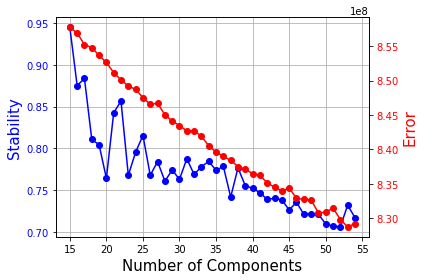

In [61]:
%%time
cnmf_obj.k_selection_plot()

In [6]:
figdir = '../../../Figures/Components'

In [7]:
cmd = 'cp {} {}'.format(cnmf_obj.paths['k_selection_plot'], 
                           os.path.join(figdir, '%s.k_selection.png' % name))

print(cmd)

cp ../../../Data/PerDataset/TBRU/TBRU.20231009/TBRU.20231009.k_selection.png ../../../Figures/Components/TBRU.20231009.k_selection.png


In [8]:
print(cmd)
! {cmd}

cp ../../../Data/PerDataset/TBRU/TBRU.20231009/TBRU.20231009.k_selection.png ../../../Figures/Components/TBRU.20231009.k_selection.png


In [7]:
kthresh = {25:.15, 29:.15, 31:.14, 34: .15, 36: .15, 38:.15, 46:.15}

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


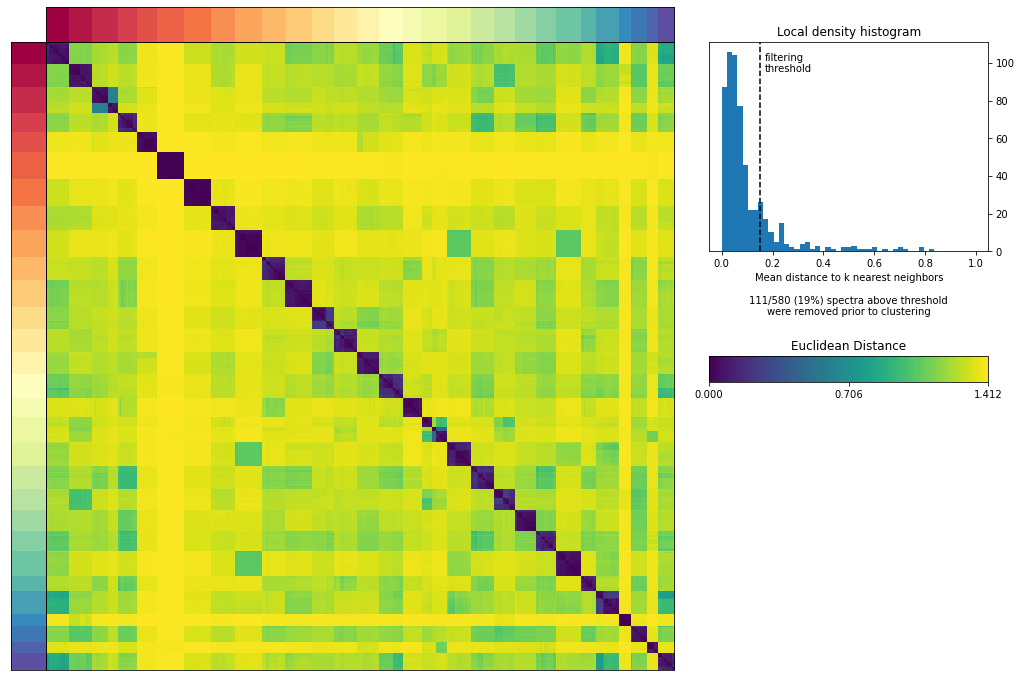

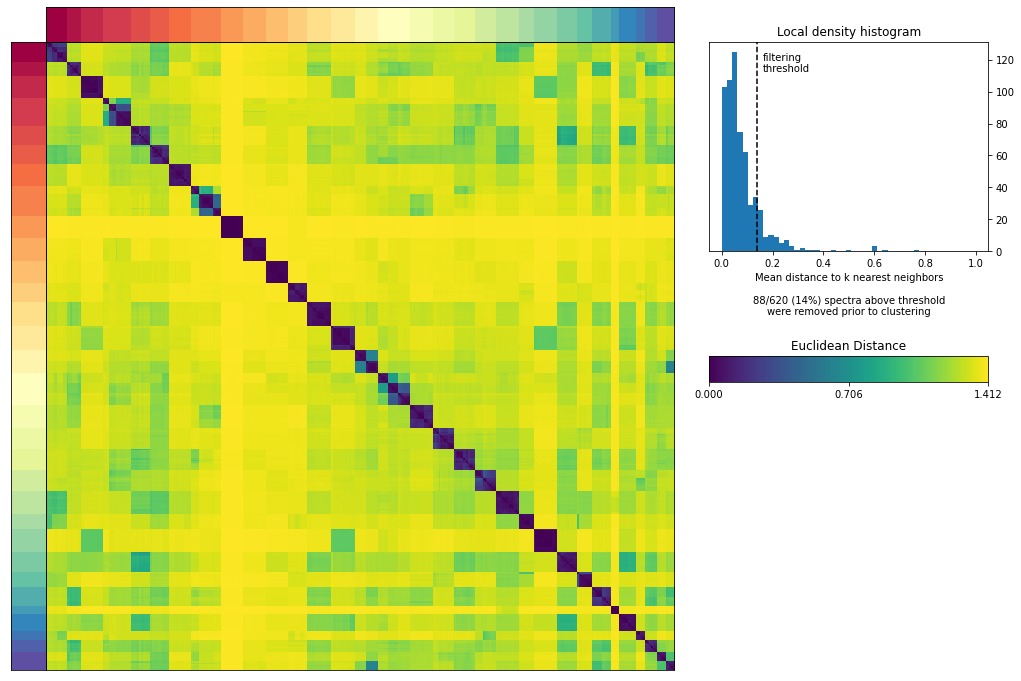

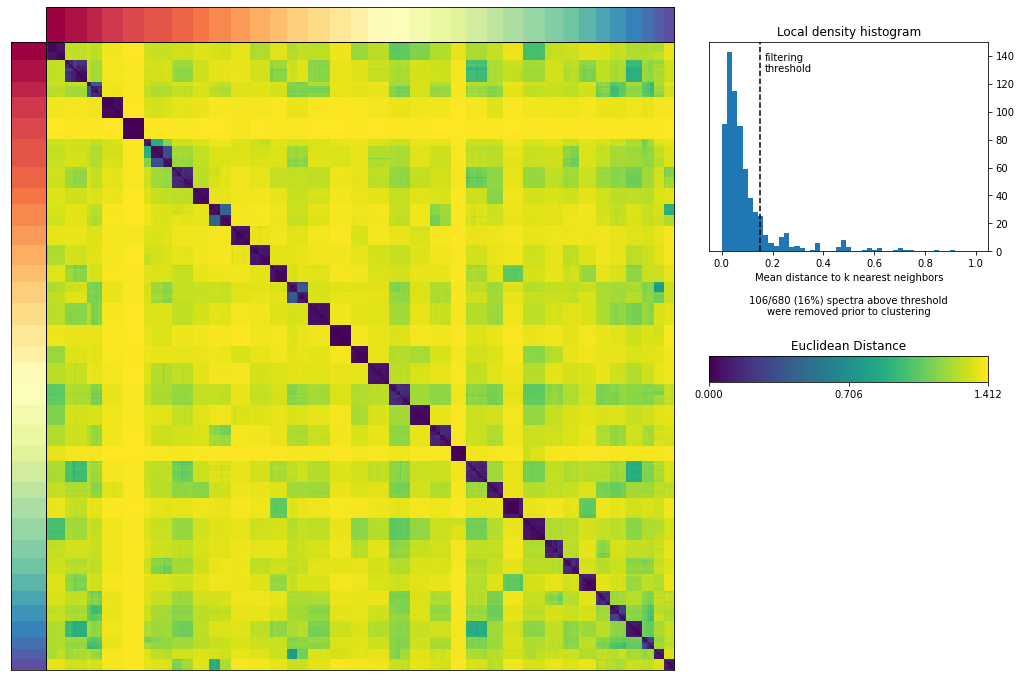

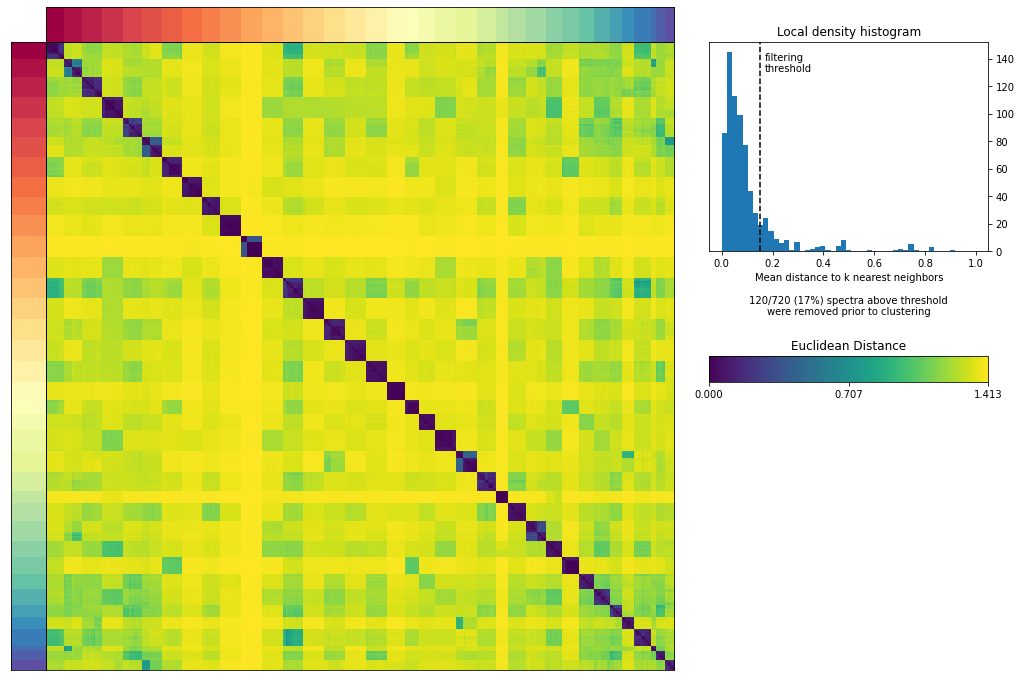

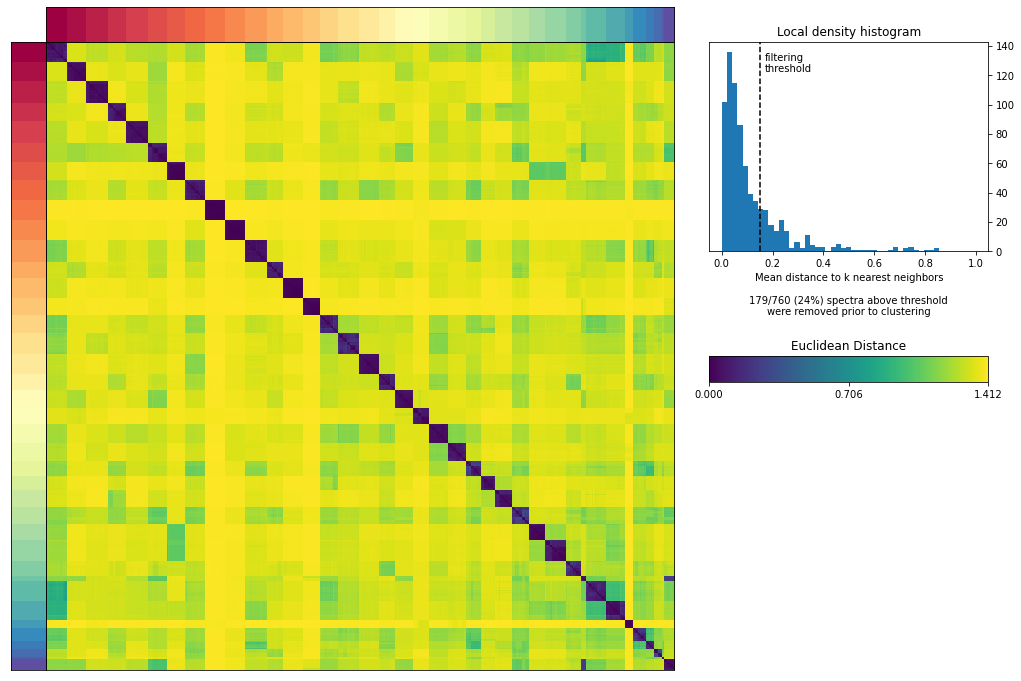

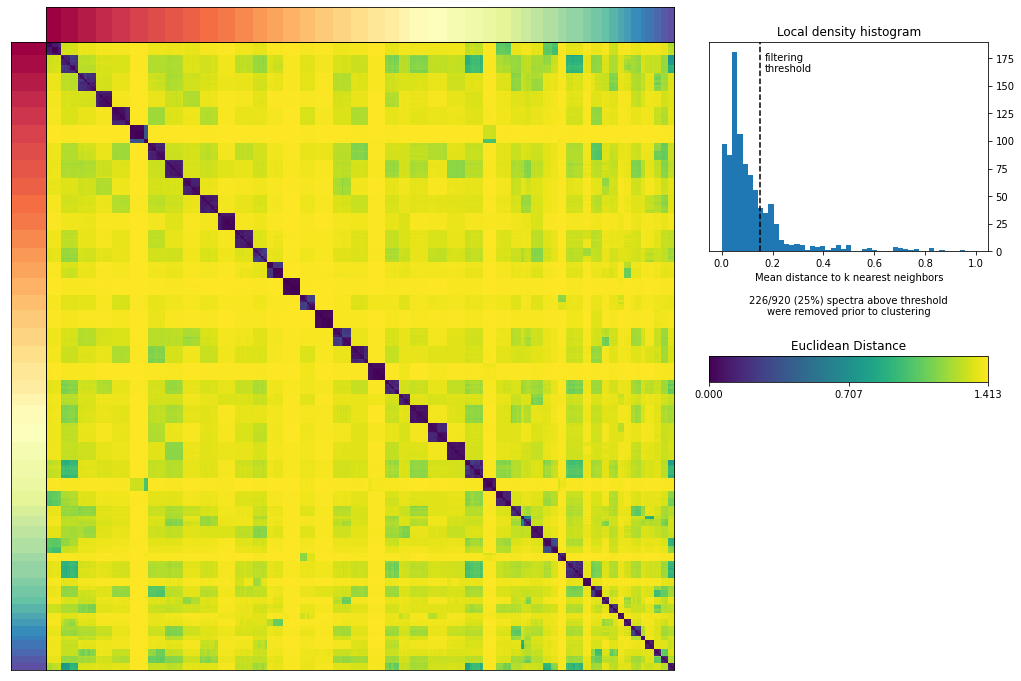

In [66]:
for k in kthresh.keys():
    cnmf_obj.consensus(k=k, density_threshold=kthresh[k])

## Compare with original TCATs

In [8]:
metagepinfo = read_dataset_log(tabname='Current Meta-program Paths').loc[0,:]
metagepinfo

clustering_fn                      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn      /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                        /data/srlab1/TCAT/Data/TCAT/MergedHVG.UnionAll...
tpm_norm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_norm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                     /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
Name: 0, dtype: object

In [9]:
clustering = pd.read_csv(metagepinfo.loc['clustering_with_singletons_fn'], sep='\t', index_col=0)
clustering.head()

AMP-RA  \
CellCycle-G2M_CellCycle_G2M                  AMP-RA:CellCycle-G2M   
ISG                                                    AMP-RA:ISG   
gdT                                                           NaN   
Metallothionein                            AMP-RA:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  AMP-RA:CellCycle-Sphase   

                                                          UK-Covid  \
CellCycle-G2M_CellCycle_G2M                 UK-Covid:CellCycle_G2M   
ISG                                                   UK-Covid:ISG   
gdT                                                   UK-Covid:gdT   
Metallothionein                           UK-Covid:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      UK-Covid:CellCycle_S   

                                                           Pan-Tissue  \
CellCycle-G2M_CellCycle_G2M                  Pan-Tissue:CellCycle-G2M   
ISG                                                    Pan-Tissue:ISG   
gdT                                                               NaN   
Metallothionein                            Pan-Tissue:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Tissue:CellCycle-Sphase   

                                                        HIV-Vaccine  \
CellCycle-G2M_CellCycle_G2M               HIV-Vaccine:CellCycle_G2M   
ISG                                                 HIV-Vaccine:ISG   
gdT                                                 HIV-Vaccine:gdT   
Metallothionein                                                 NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    HIV-Vaccine:CellCycle_S   

                                                          COMBAT  \
CellCycle-G2M_CellCycle_G2M                 COMBAT:CellCycle_G2M   
ISG                                                   COMBAT:ISG   
gdT                                                   COMBAT:gdT   
Metallothionein                           COMBAT:Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      COMBAT:CellCycle_S   

                                                        TBRU  \
CellCycle-G2M_CellCycle_G2M               TBRU:CellCycle_G2M   
ISG                                                 TBRU:ISG   
gdT                                                 TBRU:gdT   
Metallothionein                                          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B    TBRU:DTL/FAM111B   

                                                           Pan-Cancer  
CellCycle-G2M_CellCycle_G2M                  Pan-Cancer:CellCycle-G2M  
ISG                                                    Pan-Cancer:ISG  
gdT                                                               NaN  
Metallothionein                            Pan-Cancer:Metallothionein  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Pan-Cancer:CellCycle-Sphase

In [10]:
tcat_spectra_all = pd.read_csv(metagepinfo.loc['scores_spectra'], sep='\t', index_col=0).T

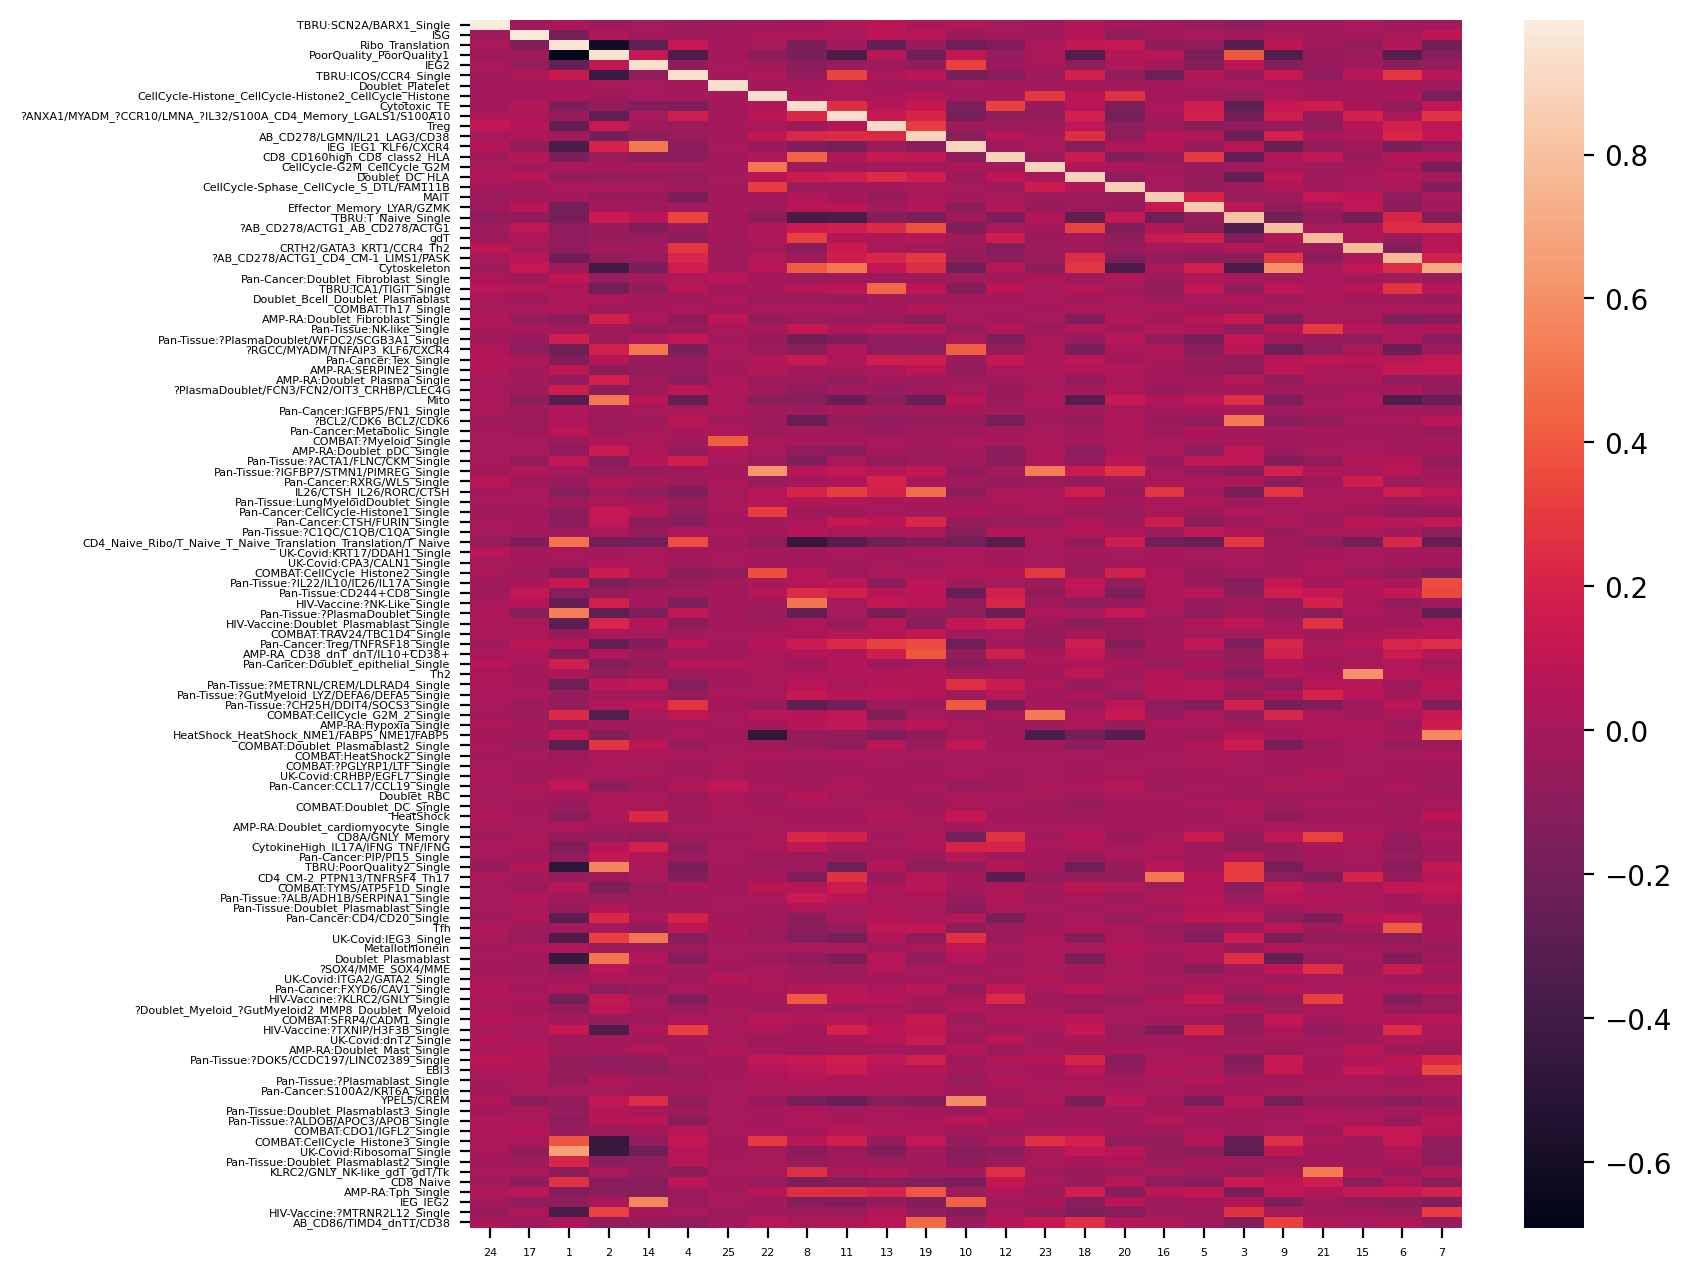

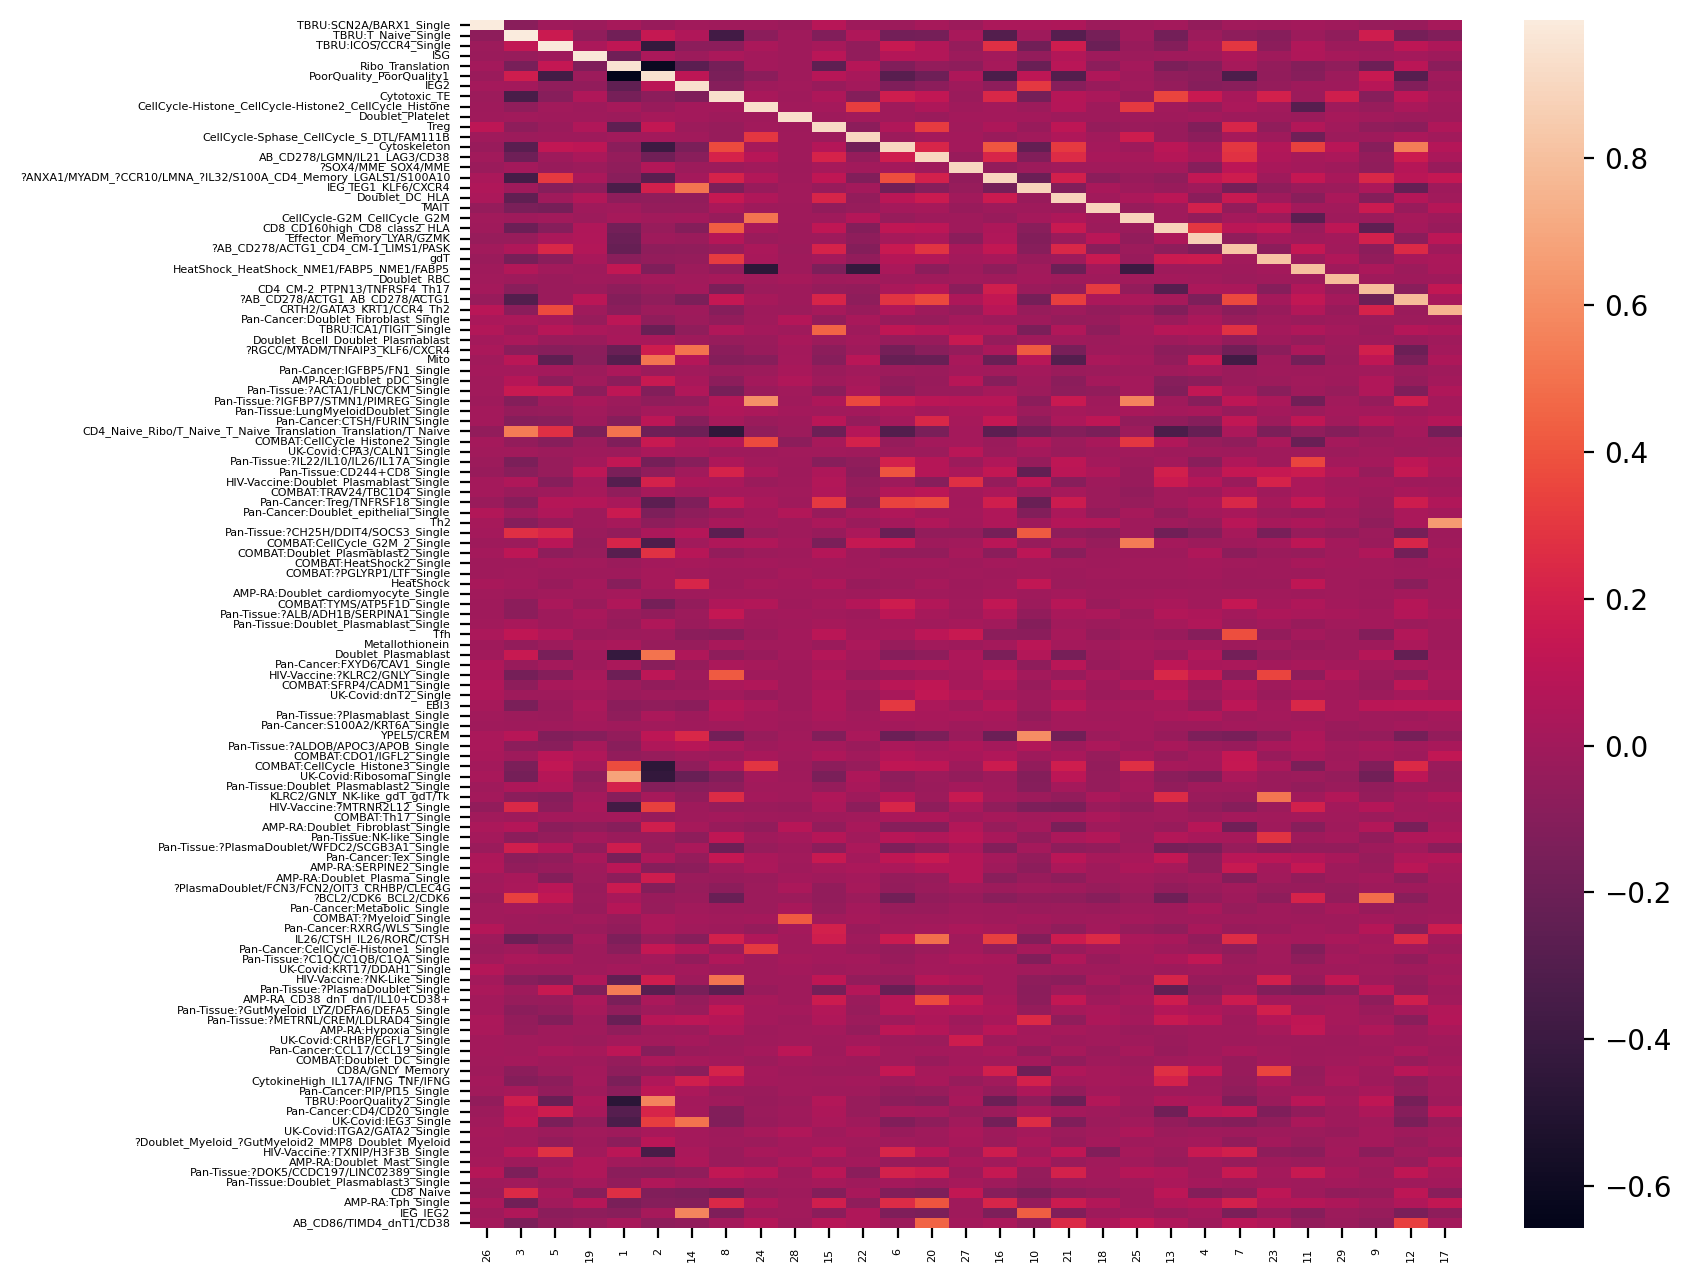

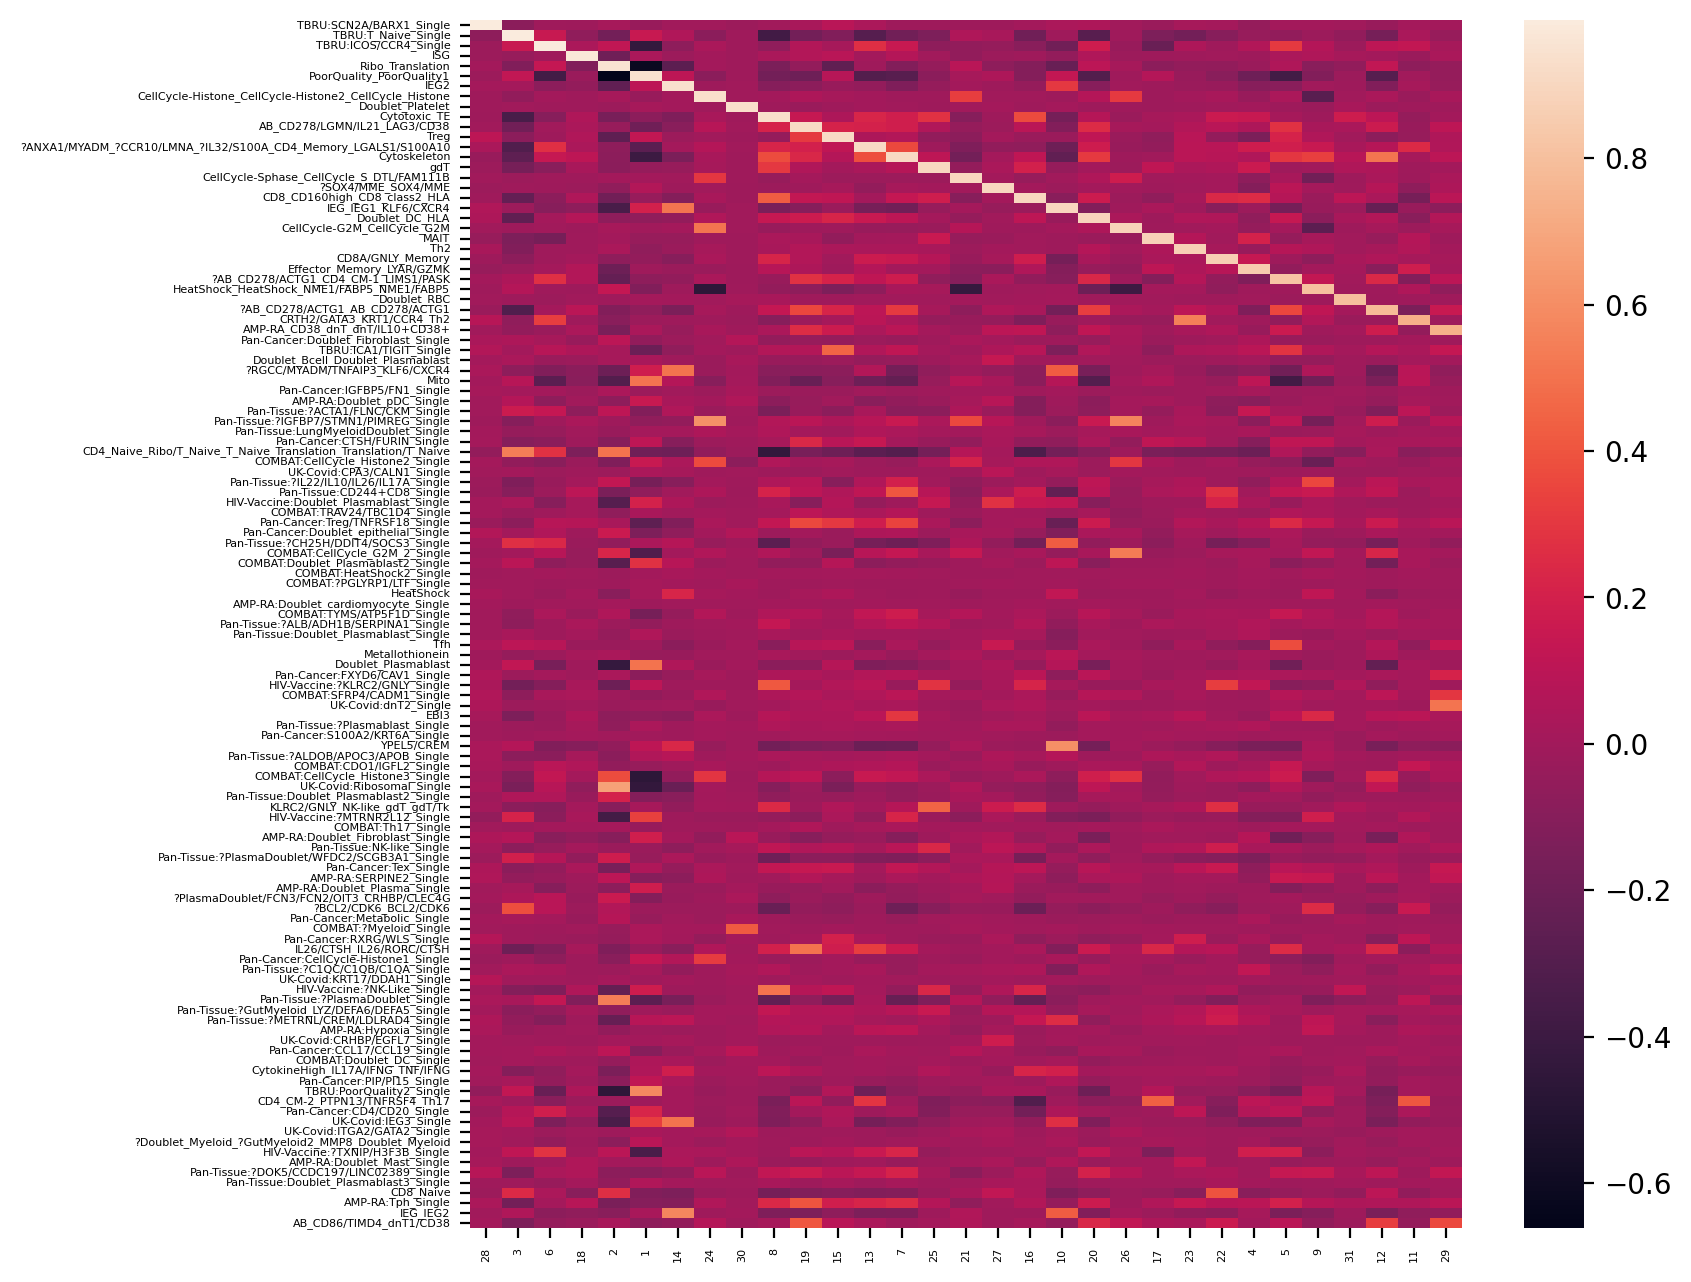

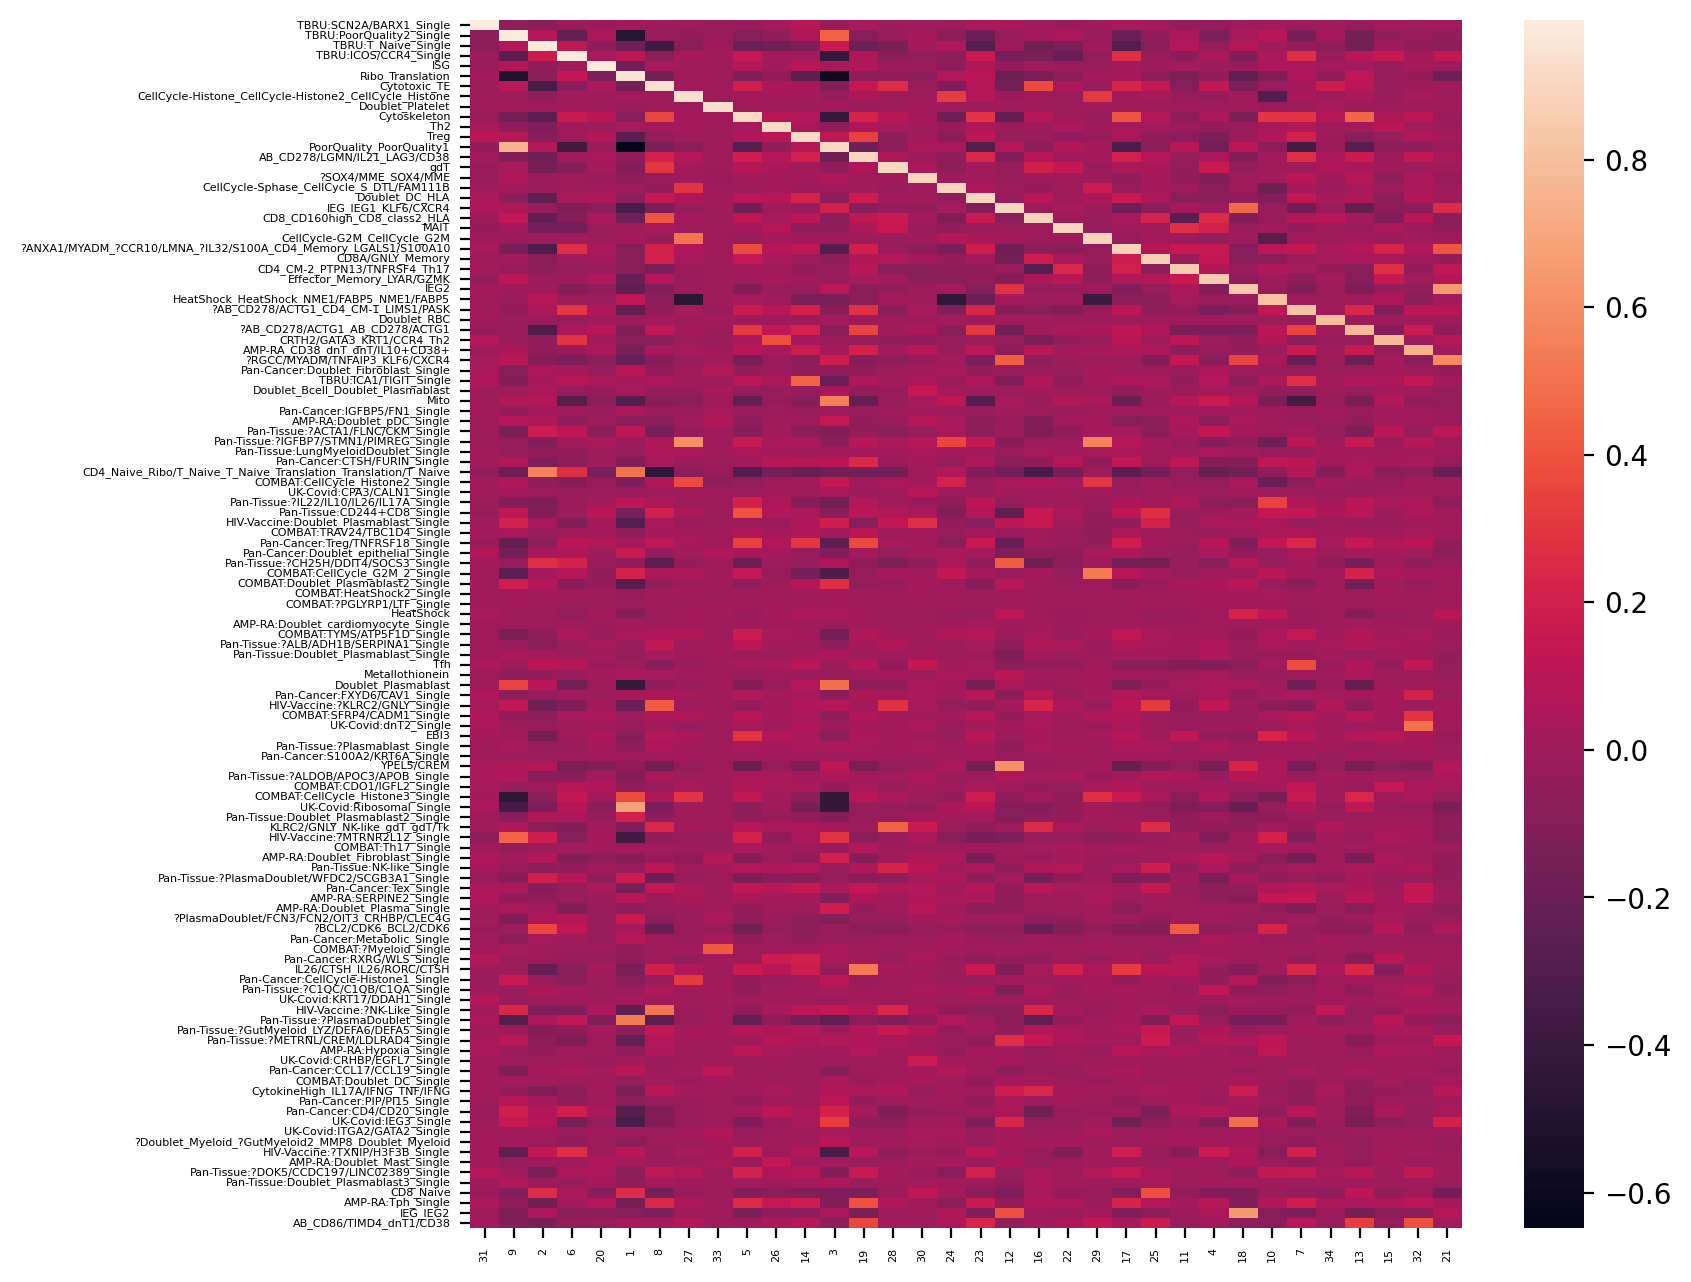

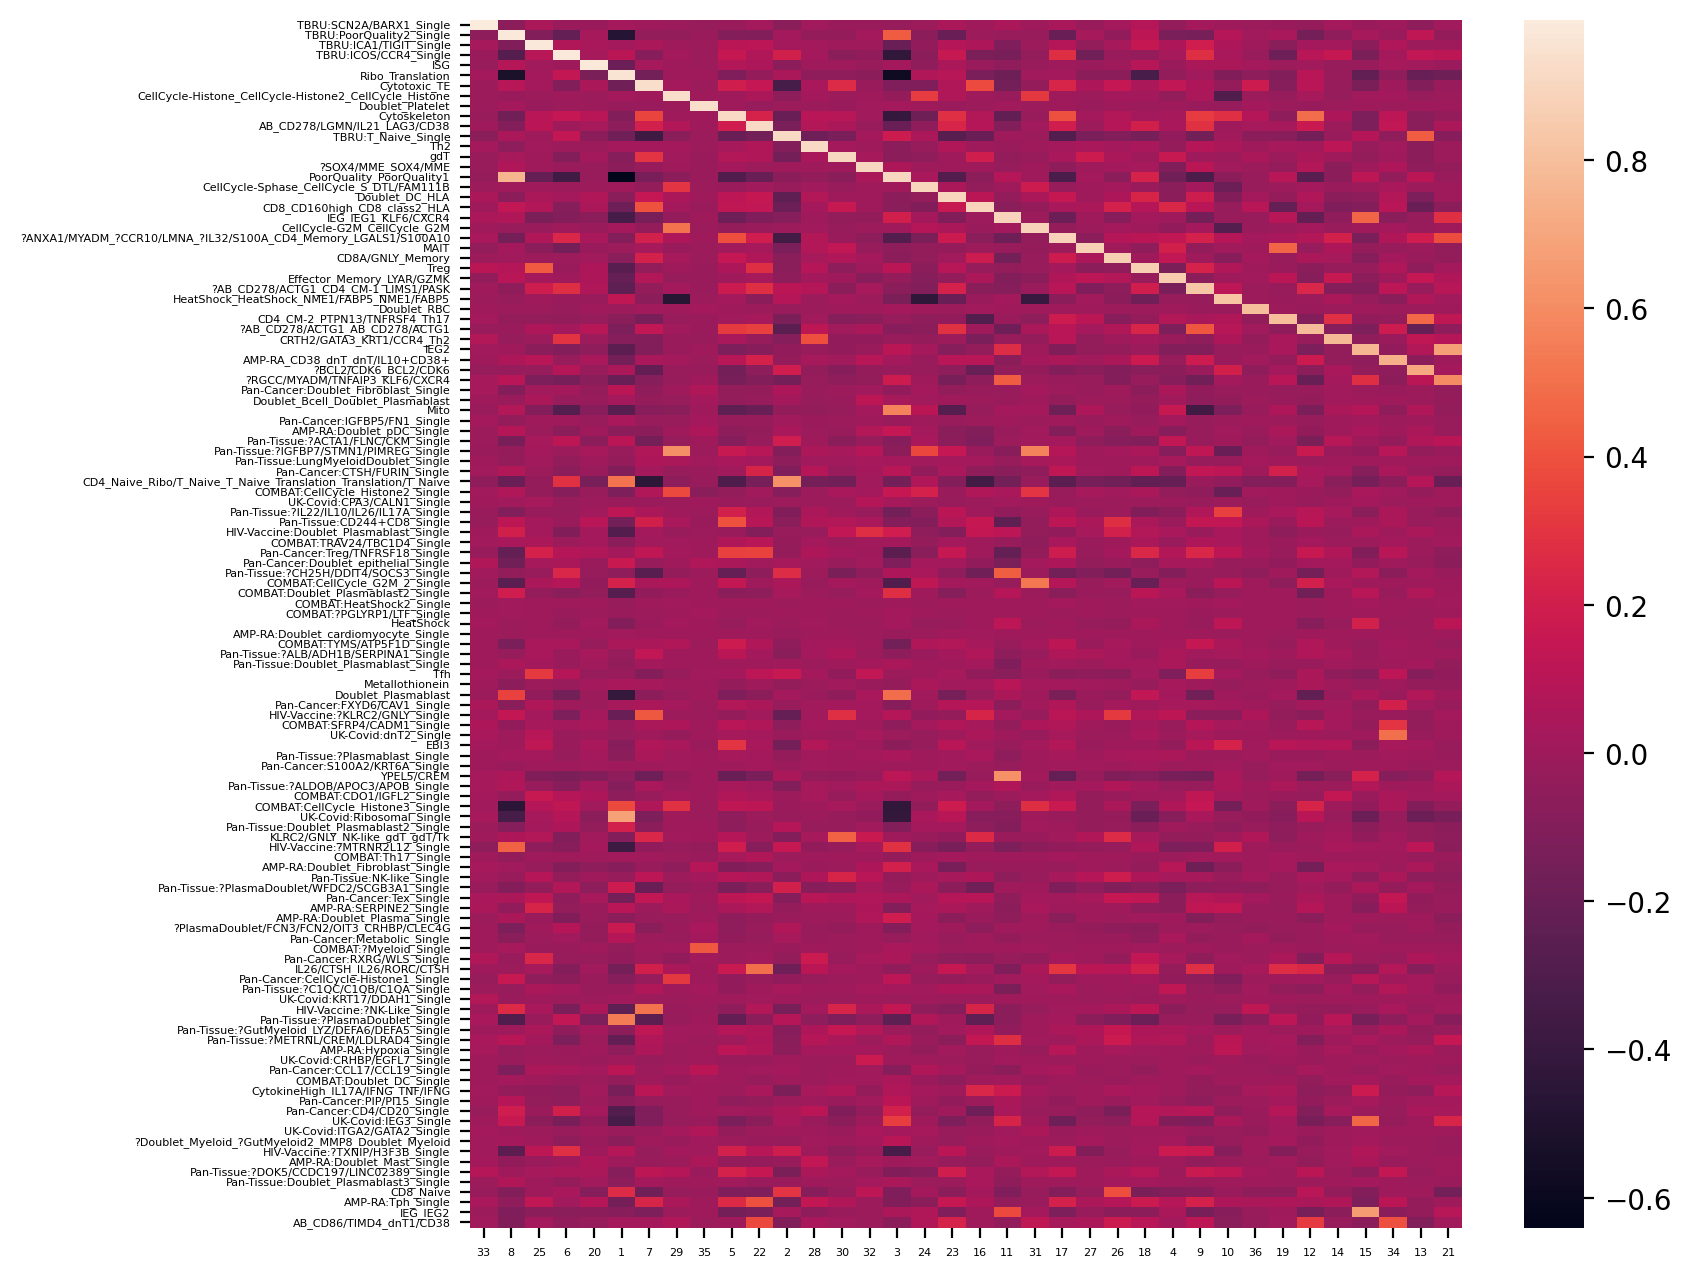

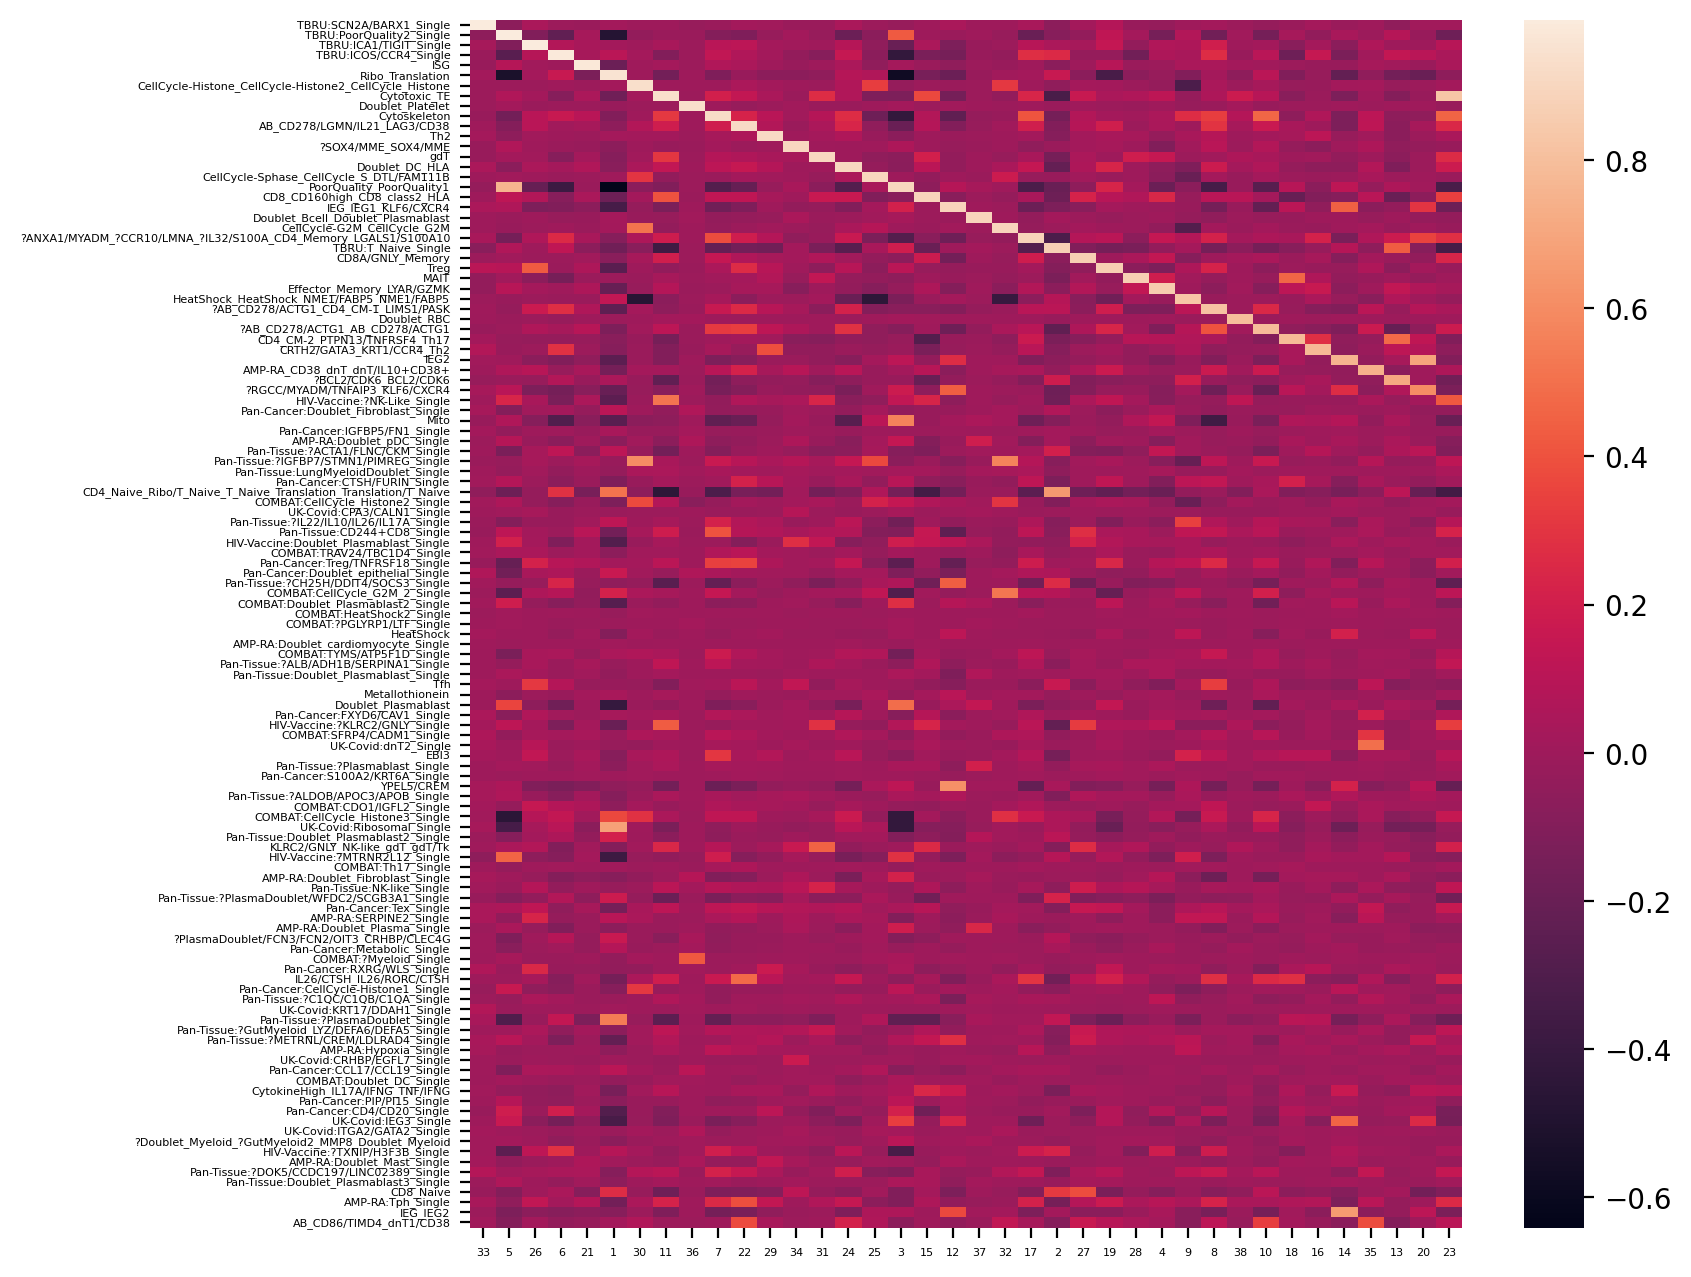

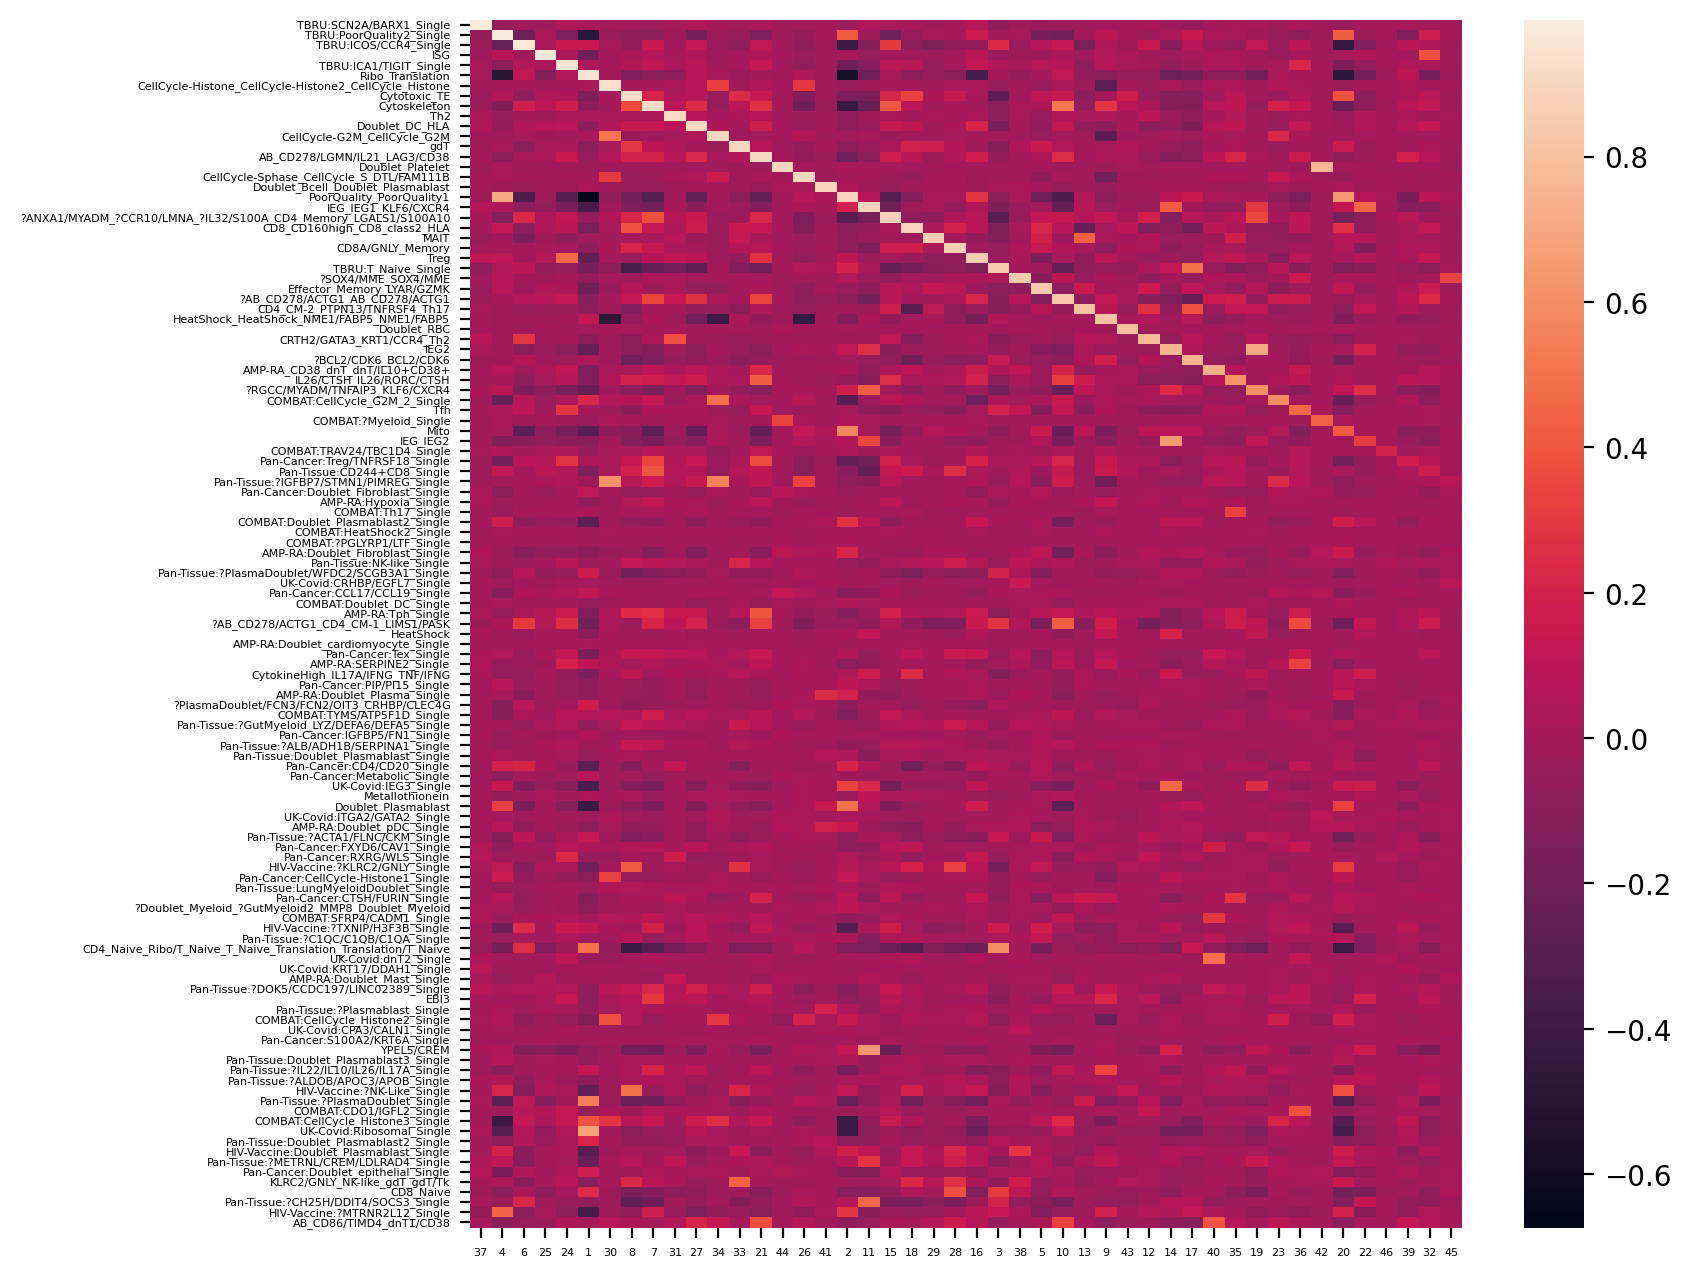

In [11]:
res = []
R_thresh = 0.55
dataset_cols = ['AMP-RA', 'UK-Covid', 'Pan-Tissue', 'HIV-Vaccine', 'COMBAT', 'TBRU', 'Pan-Cancer']
this_datset = 'TBRU'
other_dataset_cols = list(set(dataset_cols) - set([this_datset]))
mapping_ref = {}
top_genes_relabeled = {}

for k in kthresh.keys():
    (usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=k, density_threshold=kthresh[k])
    overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
    mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
    R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
    rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
    top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
    top_genes_relabeled[k] = top_genes

    fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
    sns.heatmap(R_for_plot, ax=ax)
    ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
    ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
    ax.set_xticklabels(R_for_plot.columns, fontsize=4)
    ax.set_yticklabels(R_for_plot.index, fontsize=4)

    merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
    mapping_ref[k] = merge_annotation
    total_overlaps = (merge_annotation['R']>R_thresh).sum()
    ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
    nonsingleton_overlaps = ind.sum()
    this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
    recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
    new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
    res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])


In [128]:
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  25                25                             22   
1  29                29                             26   
2  31                31                             28   
3  34                34                             30   
4  36                36                             31   
5  38                37                             32   
6  46                38                             32   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             5                      3               0   
1                             5                      3               0   
2                             5                      3               0   
3                             5                      4               0   
4                             5                      5               0   
5                             5                      5               1   
6                             5                      5               8   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
5                                       0  
6                                       1

In [129]:
set(mapping_ref[29].loc[mapping_ref[29]['R']>R_thresh, 'X_columns']) - set(mapping_ref[25].loc[mapping_ref[25]['R']>R_thresh, 'X_columns'])


{'?SOX4/MME_SOX4/MME',
 'CD4_CM-2_PTPN13/TNFRSF4_Th17',
 'Doublet_RBC',
 'HeatShock_HeatShock_NME1/FABP5_NME1/FABP5'}

In [130]:
set(mapping_ref[31].loc[mapping_ref[31]['R']>R_thresh, 'X_columns']) - set(mapping_ref[29].loc[mapping_ref[29]['R']>R_thresh, 'X_columns'])


{'AMP-RA_CD38_dnT_dnT/IL10+CD38+', 'CD8A/GNLY_Memory', 'Th2'}

In [131]:
set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns']) - set(mapping_ref[31].loc[mapping_ref[31]['R']>R_thresh, 'X_columns'])


{'?RGCC/MYADM/TNFAIP3_KLF6/CXCR4',
 'CD4_CM-2_PTPN13/TNFRSF4_Th17',
 'TBRU:PoorQuality2_Single'}

In [132]:
mapping_ref[34].loc[mapping_ref[34]['X_columns']=='?RGCC/MYADM/TNFAIP3_KLF6/CXCR4', :]

Y_columns                       X_columns         R AMP-RA UK-Covid  \
2411.0       21.0  ?RGCC/MYADM/TNFAIP3_KLF6/CXCR4  0.587087    NaN      NaN   

                            Pan-Tissue HIV-Vaccine COMBAT TBRU  \
2411.0  Pan-Tissue:?RGCC/MYADM/TNFAIP3         NaN    NaN  NaN   

                   Pan-Cancer  
2411.0  Pan-Cancer:KLF6/CXCR4

In [133]:
mapping_ref[34].loc[mapping_ref[34]['X_columns']=='CD4_CM-2_PTPN13/TNFRSF4_Th17', :]

Y_columns                     X_columns         R AMP-RA  \
1222.0       11.0  CD4_CM-2_PTPN13/TNFRSF4_Th17  0.857615    NaN   

             UK-Covid Pan-Tissue       HIV-Vaccine           COMBAT  \
1222.0  UK-Covid:Th17        NaN  HIV-Vaccine:Th17  COMBAT:CD4_CM-2   

                       TBRU Pan-Cancer  
1222.0  TBRU:PTPN13/TNFRSF4        NaN

In [134]:
set(mapping_ref[36].loc[mapping_ref[36]['R']>R_thresh, 'X_columns']) - set(mapping_ref[34].loc[mapping_ref[34]['R']>R_thresh, 'X_columns'])


{'?BCL2/CDK6_BCL2/CDK6', 'TBRU:ICA1/TIGIT_Single'}

In [135]:
mapping_ref[36].loc[mapping_ref[36]['X_columns']=='?BCL2/CDK6_BCL2/CDK6', :]

Y_columns             X_columns         R AMP-RA            UK-Covid  \
1451.0       13.0  ?BCL2/CDK6_BCL2/CDK6  0.706074    NaN  UK-Covid:BCL2/CDK6   

       Pan-Tissue             HIV-Vaccine COMBAT TBRU Pan-Cancer  
1451.0        NaN  HIV-Vaccine:?BCL2/CDK6    NaN  NaN        NaN

In [136]:
set(mapping_ref[38].loc[mapping_ref[38]['R']>R_thresh, 'X_columns']) - set(mapping_ref[36].loc[mapping_ref[36]['R']>R_thresh, 'X_columns'])


{'Doublet_Bcell_Doublet_Plasmablast'}

In [175]:
top_genes_relabeled[38][['CD4_CM-2_PTPN13/TNFRSF4_Th17']].head(40)

CD4_CM-2_PTPN13/TNFRSF4_Th17
0                          CTSH
1                      AB_CD196
2                         PDE4D
3                      TNFSF13B
4                          CCR6
5                       AB_CD26
6                        PTPN13
7                         NR1D1
8                        COL5A3
9                         CCL20
10                         IL7R
11                      ZFP36L1
12                          LTK
13                       NFKBIA
14                        CMTM6
15                     AB_CD127
16                   TTC39C-AS1
17                          LTB
18                         TOB1
19                        KLRB1
20                         AQP3
21                       LGALS3
22                        SASH1
23                      BHLHE40
24                        USP10
25                        FURIN
26                     TNFRSF18
27                      TNFRSF4
28                     AB_CD161
29                          FRY
30                        YWHAH
31                         RORA
32                         JAML
33                        SESN1
34                        AUTS2
35                         RORC
36                          NMU
37                        RUNX2
38                         DPP4
39                        IL4I1

In [176]:
top_genes_relabeled[38][['CD4_CM-2_PTPN13/TNFRSF4_Th17']]=='IL17A'

CD4_CM-2_PTPN13/TNFRSF4_Th17
0                          False
1                          False
2                          False
3                          False
4                          False
..                           ...
95                         False
96                         False
97                          True
98                         False
99                         False

[100 rows x 1 columns]

In [174]:
top_genes_relabeled[38].head(20).T

0          1   \
TBRU:SCN2A/BARX1_Single                                 SCN2A      BARX1   
TBRU:PoorQuality2_Single                                SYNE2     GOLGB1   
TBRU:ICA1/TIGIT_Single                                   ICA1       CLNK   
TBRU:ICOS/CCR4_Single                                C1orf162    CYSLTR1   
ISG                                                     ISG15       IFI6   
Ribo_Translation                                         RPS2       RPL3   
CellCycle-Histone_CellCycle-Histone2_CellCycle_...      UBE2C   HIST1H3G   
Cytotoxic_TE                                             GZMH     FGFBP2   
Doublet_Platelet                                       CAVIN2      TUBB1   
Cytoskeleton                                             ACTB       PFN1   
AB_CD278/LGMN/IL21_LAG3/CD38                             LGMN       LAG3   
Th2                                                     HPGDS     IL17RB   
?SOX4/MME_SOX4/MME                                       SOX4        MME   
gdT                                                      TRDC      TRGC1   
Doublet_DC_HLA                                        HLA-DRA   HLA-DRB1   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                 CDT1       TYMS   
PoorQuality_PoorQuality1                               MT-CO3     MT-CO1   
CD8_CD160high_CD8_class2_HLA                             CMC1     CCL3L1   
IEG_IEG1_KLF6/CXCR4                                     ZFP36       JUNB   
Doublet_Bcell_Doublet_Plasmablast                        CD22      TCL1A   
CellCycle-G2M_CellCycle_G2M                             CDC20      CCNB2   
?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory...     LGALS1      CCR10   
TBRU:T_Naive_Single                                      CCR7  AB_CD27-1   
CD8A/GNLY_Memory                                    LINC02446      KLRC2   
Treg                                                  AB_CD25      FOXP3   
MAIT                                                  SLC4A10      CEBPD   
Effector_Memory_LYAR/GZMK                                LYAR       GZMK   
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5            HSP90AB1       NME1   
?AB_CD278/ACTG1_CD4_CM-1_LIMS1/PASK                     LIMS1      KLRB1   
Doublet_RBC                                              HBA1       HBA2   
?AB_CD278/ACTG1_AB_CD278/ACTG1                          ACTG1      GAPDH   
CD4_CM-2_PTPN13/TNFRSF4_Th17                             CTSH   AB_CD196   
CRTH2/GATA3_KRT1/CCR4_Th2                                NEFL       KRT1   
IEG2                                                      JUN       FOSB   
AMP-RA_CD38_dnT_dnT/IL10+CD38+                          HMOX1  UNC5B-AS1   
?BCL2/CDK6_BCL2/CDK6                                     BCL2     FAM13A   
?RGCC/MYADM/TNFAIP3_KLF6/CXCR4                           RGCC      MYADM   
HIV-Vaccine:?NK-Like_Single                              GZMB     FGFBP2   

                                                          2          3   \
TBRU:SCN2A/BARX1_Single                                 TLL1        TPO   
TBRU:PoorQuality2_Single                                 NCL      SMC1A   
TBRU:ICA1/TIGIT_Single                                 TIGIT    METTL7A   
TBRU:ICOS/CCR4_Single                                   FHIT   AB_CD194   
ISG                                                      MX1      IFIT3   
Ribo_Translation                                        RPS5     EEF1B2   
CellCycle-Histone_CellCycle-Histone2_CellCycle_...     SPC25   HIST1H1B   
Cytotoxic_TE                                            NKG7       GNLY   
Doublet_Platelet                                      TREML1       NRGN   
Cytoskeleton                                            CFL1      ACTG1   
AB_CD278/LGMN/IL21_LAG3/CD38                         POU2AF1  AB_CD38-1   
Th2                                                     CHDH  GATA3-AS1   
?SOX4/MME_SOX4/MME                                    CASC15     SMIM24   
gdT                                         

In [137]:
set(mapping_ref[46].loc[mapping_ref[46]['R']>R_thresh, 'X_columns']) - set(mapping_ref[38].loc[mapping_ref[38]['R']>R_thresh, 'X_columns'])


{'COMBAT:CellCycle_G2M_2_Single', 'IL26/CTSH_IL26/RORC/CTSH'}

In [138]:
mapping_ref[46].loc[mapping_ref[46]['X_columns']=='IL26/CTSH_IL26/RORC/CTSH', :]

Y_columns                 X_columns         R AMP-RA UK-Covid  \
4090.0       35.0  IL26/CTSH_IL26/RORC/CTSH  0.609253    NaN      NaN   

                  Pan-Tissue HIV-Vaccine                 COMBAT TBRU  \
4090.0  Pan-Tissue:IL26/CTSH         NaN  COMBAT:IL26/RORC/CTSH  NaN   

       Pan-Cancer  
4090.0        NaN

In [168]:
top_genes_relabeled[46].T

0          1   \
TBRU:SCN2A/BARX1_Single                                 SCN2A      BARX1   
TBRU:PoorQuality2_Single                                SYNE2     GOLGB1   
TBRU:ICOS/CCR4_Single                                 CYSLTR1   C1orf162   
ISG                                                     ISG15       IFI6   
TBRU:ICA1/TIGIT_Single                                   ICA1      TIGIT   
Ribo_Translation                                         RPS2       RPL3   
CellCycle-Histone_CellCycle-Histone2_CellCycle_...      UBE2C   HIST1H3G   
Cytotoxic_TE                                           FGFBP2       GZMH   
Cytoskeleton                                             ACTB       PFN1   
Th2                                                     HPGDS     IL17RB   
Doublet_DC_HLA                                        HLA-DRA   HLA-DRB1   
CellCycle-G2M_CellCycle_G2M                             CDC20      CCNB2   
gdT                                                      TRDC      TRGC1   
AB_CD278/LGMN/IL21_LAG3/CD38                             LGMN       LAG3   
Doublet_Platelet                                       TREML1       NRGN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B                 CDT1      GINS2   
Doublet_Bcell_Doublet_Plasmablast                        CD22      TCL1A   
PoorQuality_PoorQuality1                               MT-CO3     MALAT1   
IEG_IEG1_KLF6/CXCR4                                      JUNB      ZFP36   
?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory...     LGALS1      CCR10   
CD8_CD160high_CD8_class2_HLA                             CMC1     CCL3L1   
MAIT                                                  SLC4A10      CEBPD   
CD8A/GNLY_Memory                                    LINC02446      KLRC2   
Treg                                                  AB_CD25      FOXP3   
TBRU:T_Naive_Single                                      CCR7  AB_CD27-1   
?SOX4/MME_SOX4/MME                                       SOX4        MME   
Effector_Memory_LYAR/GZMK                                LYAR       GZMK   
?AB_CD278/ACTG1_AB_CD278/ACTG1                          ACTG1      GAPDH   
CD4_CM-2_PTPN13/TNFRSF4_Th17                            PDE4D   AB_CD196   
HeatShock_HeatShock_NME1/FABP5_NME1/FABP5            HSP90AB1       NME1   
Doublet_RBC                                              HBA1       HBA2   
CRTH2/GATA3_KRT1/CCR4_Th2                                NEFL       KRT1   
IEG2                                                      JUN       FOSB   
?BCL2/CDK6_BCL2/CDK6                                     BCL2     FAM13A   
AMP-RA_CD38_dnT_dnT/IL10+CD38+                          HMOX1  UNC5B-AS1   
IL26/CTSH_IL26/RORC/CTSH                                 IL26      IL17A   
?RGCC/MYADM/TNFAIP3_KLF6/CXCR4                           RGCC      MYADM   
COMBAT:CellCycle_G2M_2_Single                           TROAP      BIRC5   
Tfh                                                      GNG4     CXCL13   
COMBAT:?Myeloid_Single                                 CLEC1B      TUBB1   
Mito                                                    SYNE1       ZEB2   
IEG_IEG2                                               NFKBIA       PIM3   
COMBAT:TRAV24/TBC1D4_Single                              OTX2     A4GALT   
Pan-Cancer:Treg/TNFRSF18_Single                        PHLDA3       FDXR   
Pan-Tissue:CD244+CD8_Single                             STAT1       GBP4   
Pan-Tissue:?IGFBP7/STMN1/PIMREG_Single                   DNTT     PCAT18   

                                                          2         3   \
TBRU:SCN2A/BARX1_Single                                 TLL1       TPO   
TBRU:PoorQuality2_Single                                 NCL     SMC1A   
TBRU:ICOS/CCR4_Single                                   FHIT  AB_CD194   
ISG                                                      MX1     IFIT3   
TBRU:ICA1/TIGIT_Single                                  CLNK   METTL7A   
Ribo_Translation                          

In [169]:
top_genes_relabeled[46][['IL26/CTSH_IL26/RORC/CTSH', 'CD4_CM-2_PTPN13/TNFRSF4_Th17']].head(30)

IL26/CTSH_IL26/RORC/CTSH CD4_CM-2_PTPN13/TNFRSF4_Th17
0                      IL26                        PDE4D
1                     IL17A                     AB_CD196
2                       NMU                     TNFSF13B
3                     IL17F                         CTSH
4                    COL5A3                      AB_CD26
5                   CREB3L3                         CCR6
6                    ADAM12                         TOB1
7                      CTSH                         IL7R
8                     PKHD1                     AB_CD127
9                    PTPN13                        NR1D1
10                   C2CD4B                         AQP3
11                     CA10                   TTC39C-AS1
12                    SMCO4                        CMTM6
13                    LRP12                       ADAM23
14                    NTRK2                        USP10
15                   TMIGD2                          LTB
16                     PRR5                       PTPN13
17                    PTPRD                        CCL20
18                      LTK                       LGALS3
19                  AB_CD28                        SASH1
20                 AB_CD196                          FRY
21                    FURIN                        KLRB1
22                    OSTF1                      ZFP36L1
23                     RORC                         DPP4
24                 TMEM167A                      TNFRSF4
25                    IL1R2                         NSG1
26                    LIMS1                          CR1
27                    CPNE7                          LTK
28                 C9orf139                      BHLHE40
29                   GOLIM4                        SATB1

In [139]:
top_genes_relabeled[36]['?BCL2/CDK6_BCL2/CDK6'].head(30)

0         BCL2
1       FAM13A
2          MAL
3         CISH
4          EDA
5       PTGER2
6      SLC40A1
7        USP10
8         PIM1
9         CDK6
10         LTB
11      RNF157
12    AB_CD127
13         DST
14        DPP4
15       CMTM6
16      TAGLN2
17       MDFIC
18      HDGFL3
19      PLXNA4
20      MCOLN3
21     TRABD2A
22         VIM
23       ADTRP
24       TRADD
25        IL7R
26     TMEM123
27     TMEM156
28        UPP1
29       CRIP1
Name: ?BCL2/CDK6_BCL2/CDK6, dtype: object

# Ks=[36, 46]

In [66]:
cnmfdir = '../../../Data/PerDataset/TBRU'
name = 'TBRU.20231009.Iter200'

In [67]:
cnmf_count_fn = paths['RNA_Varnorm_Harmony']
cnmf_tpm_fn = paths['RNA_and_ADT_TP10K']
hvg_fn = paths['RNA_HVG_List']

jname = name
cnmfout = os.path.join(cnmfdir, name, 'log')

Ks = np.array([36, 46])#np.arange(36, 37)
n_iter = 200
num_per_node = 4

In [14]:
total_workers = int((len(Ks)*n_iter) / num_per_node)
total_workers

100

In [11]:
Ks

array([36, 46])

In [68]:
cnmf_obj = cNMF(output_dir=cnmfdir, name=name)

In [14]:
cnmf_obj.prepare(counts_fn=cnmf_count_fn, components=Ks,
                 n_iter=n_iter, tpm_fn=cnmf_tpm_fn, genes_file=hvg_fn, init='random')

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].


In [101]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)

basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in range(total_workers):
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

bsub -q medium -J TBRU.20231009.Iter200 -o ../../../Data/PerDataset/TBRU/TBRU.20231009.Iter200/log/TBRU.20231009.Iter200.0.out.txt -e ../../../Data/PerDataset/TBRU/TBRU.20231009.Iter200/log/TBRU.20231009.Iter200.0.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "export OMP_NUM_THREADS=6; cnmf factorize --name TBRU.20231009.Iter200 --output-dir ../../../Data/PerDataset/TBRU --total-workers 50 --worker-index 0"
Job <901360> is submitted to queue <medium>.
bsub -q medium -J TBRU.20231009.Iter200 -o ../../../Data/PerDataset/TBRU/TBRU.20231009.Iter200/log/TBRU.20231009.Iter200.1.out.txt -e ../../../Data/PerDataset/TBRU/TBRU.20231009.Iter200/log/TBRU.20231009.Iter200.1.err.txt -R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]" "exp

In [ ]:
! bjobs

In [ ]:
! bjobs | wc -l

In [15]:
total_workers = int((len(Ks)*n_iter))
total_workers

400

In [21]:
import os
def worker_filter(iterable, worker_index, total_workers):
    return (p for i,p in enumerate(iterable) if (i-worker_index)%total_workers==0)

def load_df_from_npz(filename):
    with np.load(filename, allow_pickle=True) as f:
        obj = pd.DataFrame(**f)
    return obj

missing = []
run_params = load_df_from_npz(cnmf_obj.paths['nmf_replicate_parameters'])
for worker_i in range(total_workers):
    jobs_for_this_worker = worker_filter(range(len(run_params)), worker_i, total_workers)
    for idx in jobs_for_this_worker:
        p = run_params.iloc[idx, :]
        outfn = cnmf_obj.paths['iter_spectra'] % (p['n_components'], p['iter'])
        if not os.path.exists(outfn):
            print(worker_i, outfn)
            missing.append(worker_i)
            
len(missing)

0

In [ ]:
if not os.path.exists(cnmfout): os.mkdir(cnmfout)
basecmd = "export OMP_NUM_THREADS=6; cnmf factorize --name {name} --output-dir {outdir} --total-workers {tw} --worker-index {i}"
q = 'medium'
other = '-R "rusage[mem=2000]" -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"'

for i in missing:
    cmd = basecmd.format(name=name, outdir=cnmfdir, i=i, tw=total_workers)
    e = os.path.join(cnmfout, '{j}.{i}.err.txt').format(i=i, j=jname)
    o = os.path.join(cnmfout, '{j}.{i}.out.txt').format(i=i, j=jname)
    bsub_cmd = 'bsub -q {q} -J {j} -o {o} -e {e} {other} "{cmd}"'.format(q=q, j=jname, e=e, o=o, other=other, cmd=cmd)
    print(bsub_cmd)
    !{bsub_cmd}

In [ ]:
total_workers = int((len(Ks)*n_iter))
total_workers

In [104]:
# cnmf_obj.combine(skip_missing_files=True)

Combining factorizations for k=36.


In [22]:
cnmf_obj.combine(components = [46], skip_missing_files=False)

Combining factorizations for k=46.


Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


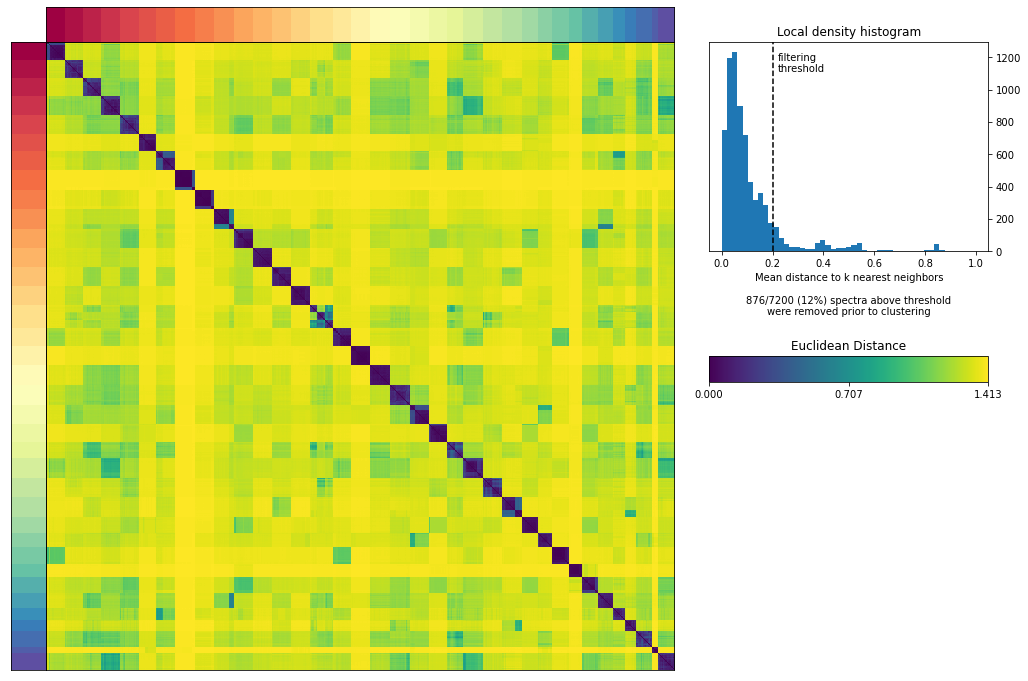

In [105]:
cnmf_obj.consensus(k=36, density_threshold=0.2)

Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].
Only considering the two last: ['.tpm', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


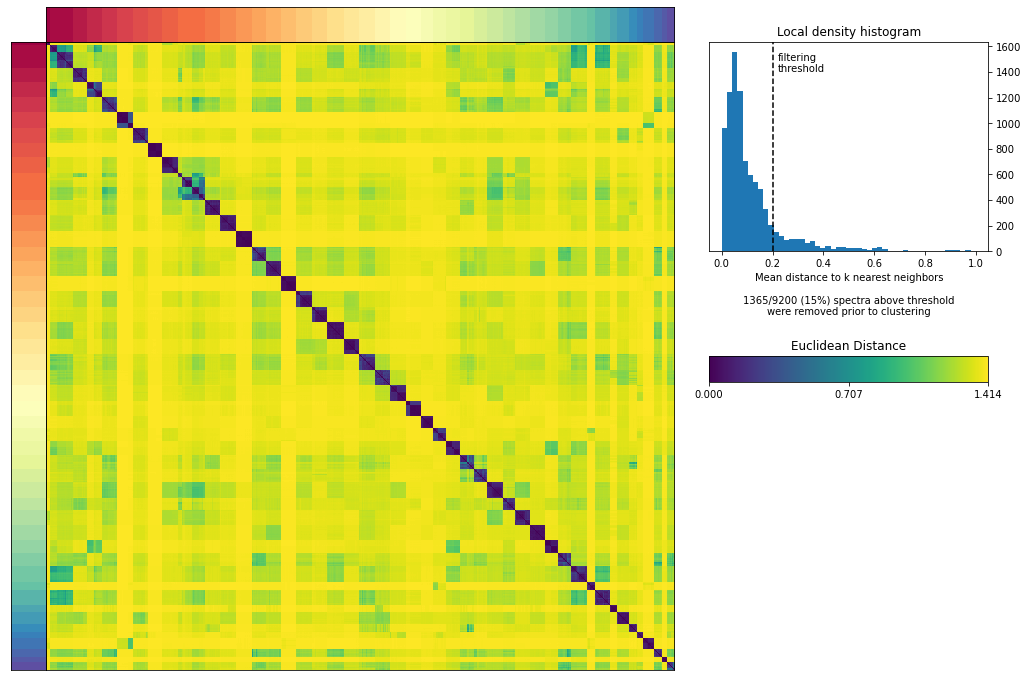

In [23]:
cnmf_obj.consensus(k=46, density_threshold=0.2)

## Look at the results for Ks with 200 iterations

In [69]:
top_genes_relabeled = {}

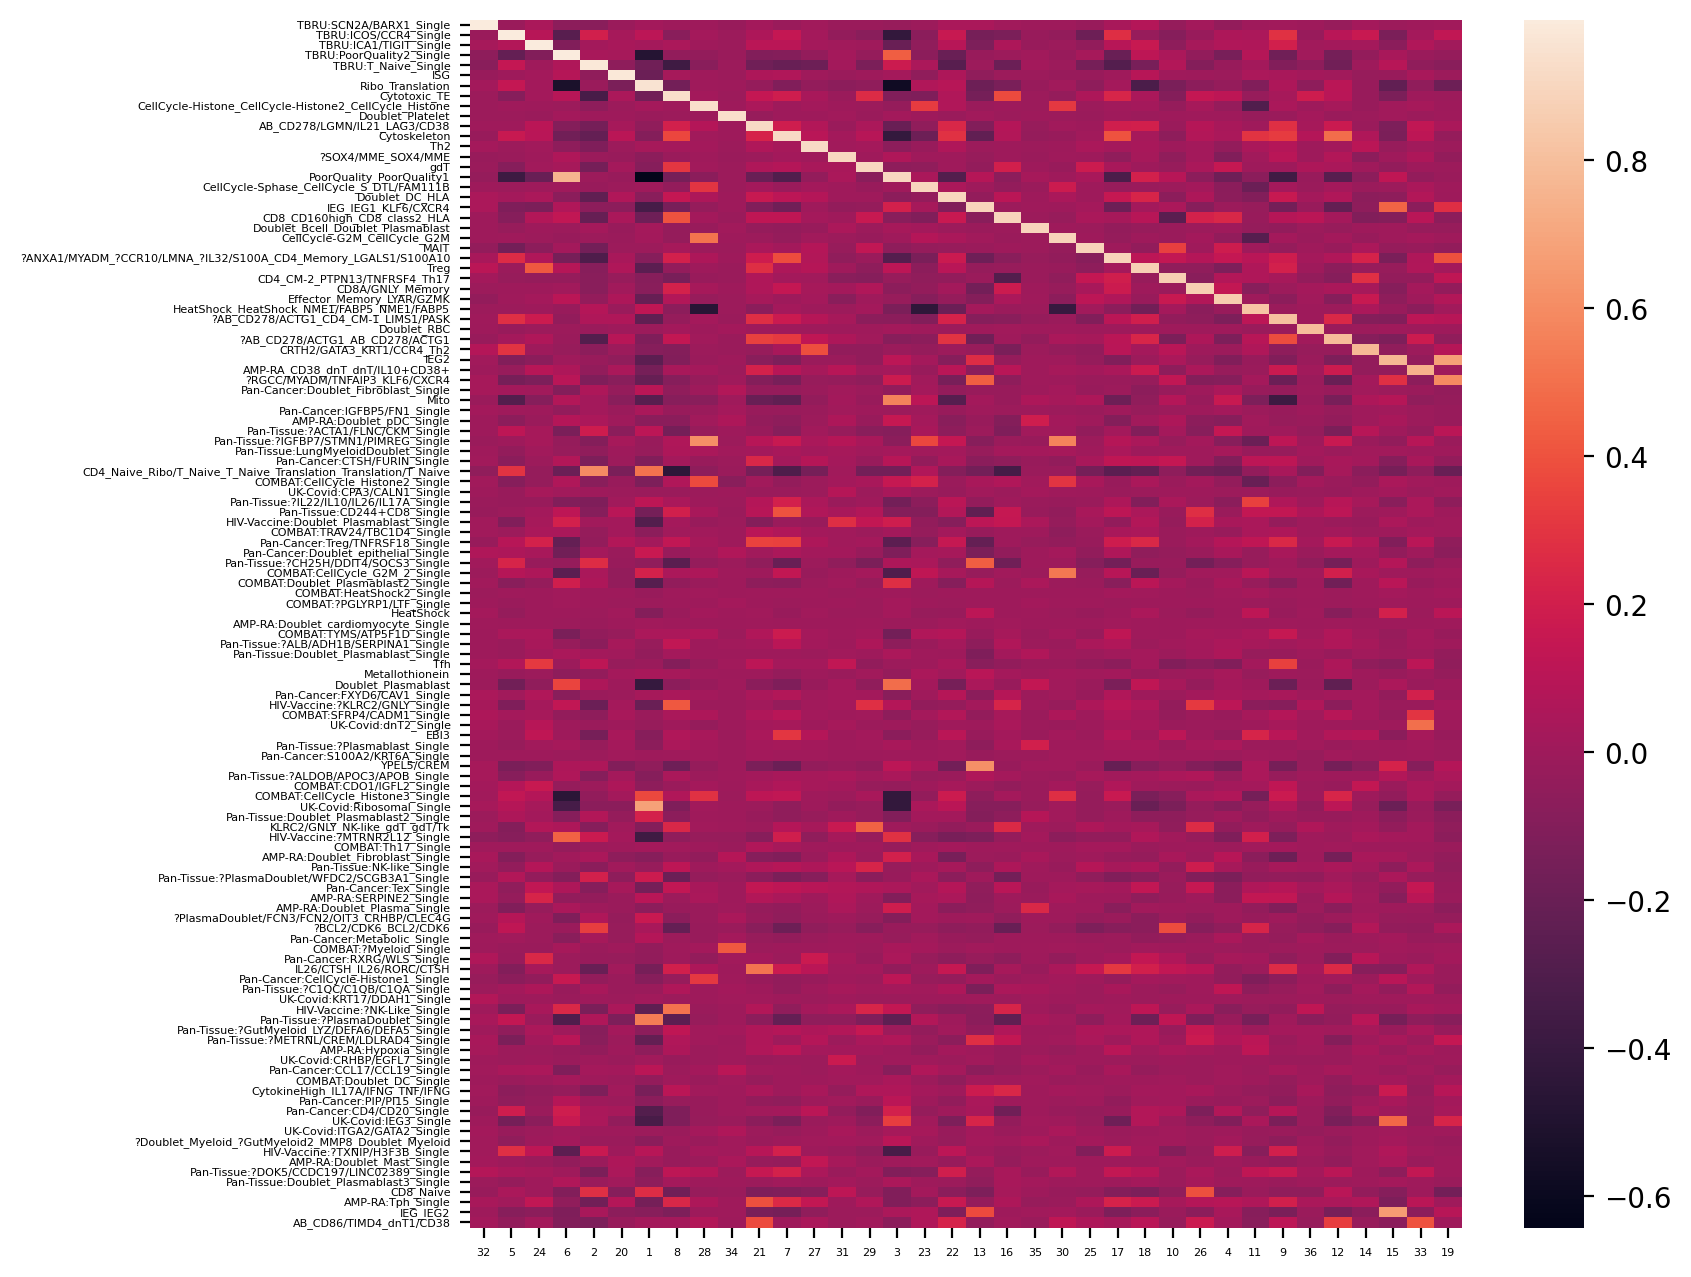

In [70]:
k=36
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=36, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
top_genes_relabeled[k] = top_genes

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [71]:
res = []
k=36
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])

    
    
# res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
# res

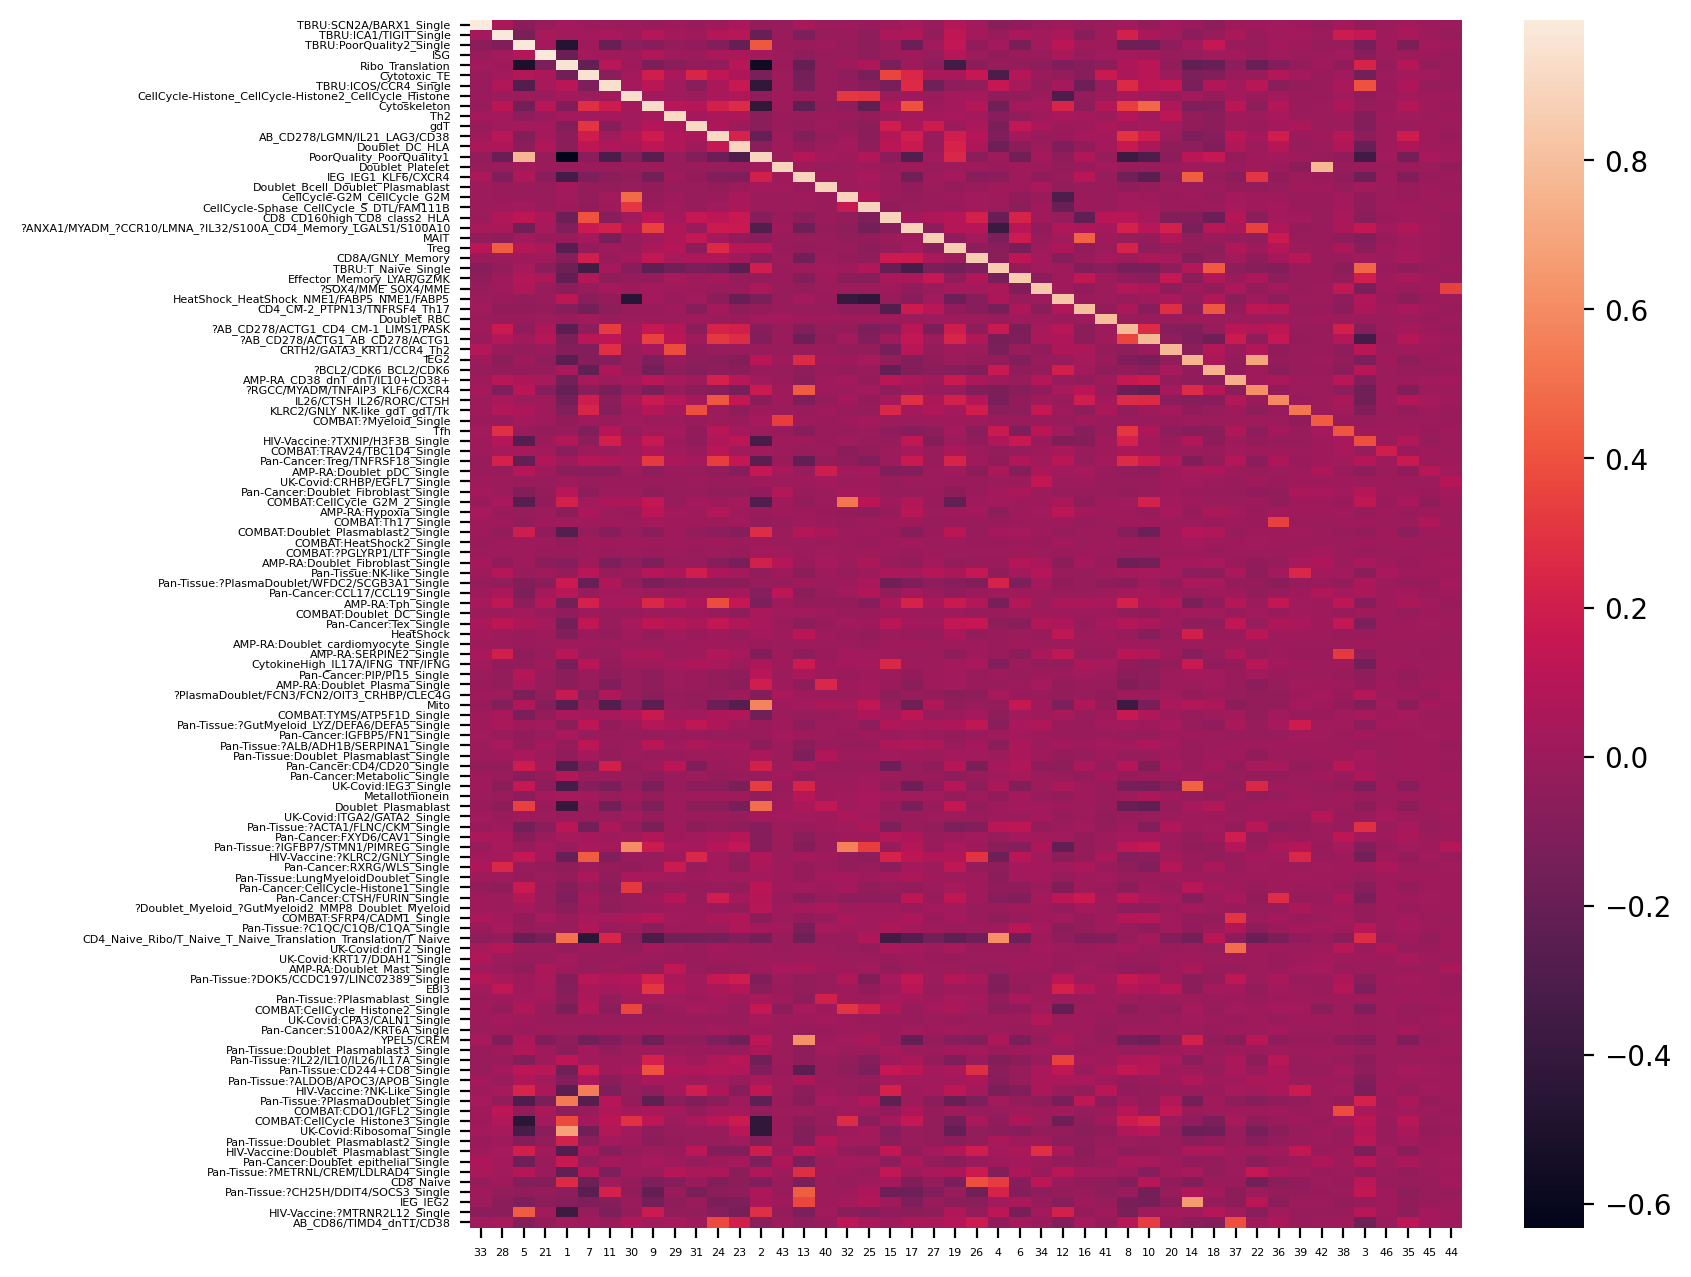

In [72]:
k=46
(usage, spectra_scores, spectra_tpm, top_genes) = cnmf_obj.load_results(K=46, density_threshold=0.2)
overlap_genes = list(set(spectra_scores.index).intersection(tcat_spectra_all.index))
mapping, unmatched, R = match_columns(tcat_spectra_all.loc[overlap_genes, :], spectra_scores.loc[overlap_genes, :])
R_for_plot = R.loc[list(mapping['X_columns']) + unmatched, mapping['Y_columns']]
rename_dict = dict(zip(mapping['Y_columns'], mapping['X_columns']))
top_genes = top_genes.rename(columns=rename_dict).loc[:, mapping['X_columns']]
top_genes_relabeled[k] = top_genes

fig,ax = plt.subplots(1,1, figsize=(8,8), dpi=200)
sns.heatmap(R_for_plot, ax=ax)
ax.set_xticks(np.arange(R_for_plot.shape[1])+0.5)
ax.set_yticks(np.arange(R_for_plot.shape[0])+0.5)
ax.set_xticklabels(R_for_plot.columns, fontsize=4)
_ = ax.set_yticklabels(R_for_plot.index, fontsize=4)

In [73]:
# res = []
k=46
merge_annotation = pd.merge(left=mapping, right=clustering, left_on='X_columns', right_index=True, how='outer')
mapping_ref[k] = merge_annotation
total_overlaps = (merge_annotation['R']>R_thresh).sum()
ind = (merge_annotation['R']>R_thresh) & ((~merge_annotation[dataset_cols].isnull()).sum(axis=1)>1)
nonsingleton_overlaps = ind.sum()
this_dataset_singletons_ind = (~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==0
recur_singleton_ind = this_dataset_singletons_ind & (merge_annotation['R']>R_thresh)
new_singleton_match_ind = ((~merge_annotation[other_dataset_cols].isnull()).sum(axis=1)==1) & (merge_annotation['R']>R_thresh) & merge_annotation[this_datset].isnull()
res.append([k, total_overlaps, nonsingleton_overlaps, this_dataset_singletons_ind.sum(), recur_singleton_ind.sum(), (merge_annotation['R']<R_thresh).sum(), new_singleton_match_ind.sum()])
    
res = pd.DataFrame(res, columns=['K', 'Num_GEP_Overlaps', 'Num_TCAT_NonSingletonOverlaps', 'Orig_TCAT_Dataset_Singletons', 'TCAT_Singletons_Found', 'New_Singletons', 'Orig_TCAT_OtherDataset_Singleton_Match'])
res

K  Num_GEP_Overlaps  Num_TCAT_NonSingletonOverlaps  \
0  36                36                             31   
1  46                38                             33   

   Orig_TCAT_Dataset_Singletons  TCAT_Singletons_Found  New_Singletons  \
0                             5                      5               0   
1                             5                      5               8   

   Orig_TCAT_OtherDataset_Singleton_Match  
0                                       0  
1                                       0

In [63]:
mapping_ref[46][mapping_ref[46]['X_columns']=='?BCL2/CDK6_BCL2/CDK6']

Y_columns             X_columns         R AMP-RA            UK-Covid  \
2046.0       18.0  ?BCL2/CDK6_BCL2/CDK6  0.753192    NaN  UK-Covid:BCL2/CDK6   

       Pan-Tissue             HIV-Vaccine COMBAT TBRU Pan-Cancer  
2046.0        NaN  HIV-Vaccine:?BCL2/CDK6    NaN  NaN        NaN

In [56]:
set(mapping_ref[46].loc[mapping_ref[46]['R']>R_thresh, 'X_columns']) - set(mapping_ref[36].loc[mapping_ref[36]['R']>R_thresh, 'X_columns'])


{'?BCL2/CDK6_BCL2/CDK6', 'IL26/CTSH_IL26/RORC/CTSH'}

In [64]:
mapping_ref[46][mapping_ref[46]['X_columns']=='IL26/CTSH_IL26/RORC/CTSH']

Y_columns                 X_columns        R AMP-RA UK-Covid  \
4209.0       36.0  IL26/CTSH_IL26/RORC/CTSH  0.58717    NaN      NaN   

                  Pan-Tissue HIV-Vaccine                 COMBAT TBRU  \
4209.0  Pan-Tissue:IL26/CTSH         NaN  COMBAT:IL26/RORC/CTSH  NaN   

       Pan-Cancer  
4209.0        NaN

In [47]:
set(mapping_ref[36].loc[mapping_ref[36]['R']>R_thresh, 'X_columns']) - set(mapping_ref[46].loc[mapping_ref[46]['R']>R_thresh, 'X_columns'])


set()

In [59]:
top_genes_relabeled[46]['?BCL2/CDK6_BCL2/CDK6'].head(40)

0         BCL2
1       FAM13A
2         CISH
3          MAL
4          EDA
5      SLC40A1
6         PIM1
7        USP10
8         CDK6
9       PTGER2
10         DST
11      RNF157
12         LTB
13      HDGFL3
14       ADTRP
15      PLXNA4
16       CMTM6
17    AB_CD127
18      MCOLN3
19        DPP4
20     TMEM156
21       MDFIC
22     TRABD2A
23      TAGLN2
24      RASSF6
25       DACT1
26        UPP1
27     TMEM123
28       TRADD
29        LEF1
30      IGFBP3
31       SOCS3
32        ANK3
33       IGF1R
34         VIM
35         CR1
36     ARHGAP5
37       ITGA4
38        GLUL
39        IL7R
Name: ?BCL2/CDK6_BCL2/CDK6, dtype: object

In [60]:
top_genes_relabeled[46]['IL26/CTSH_IL26/RORC/CTSH'].head(40)

0         IL26
1        IL17A
2          NMU
3        IL17F
4       COL5A3
5      CREB3L3
6       ADAM12
7         CTSH
8        PKHD1
9       C2CD4B
10        CA10
11      PTPN13
12       SMCO4
13       LRP12
14       NTRK2
15        PRR5
16       PTPRD
17      TMIGD2
18         LTK
19     AB_CD28
20       OSTF1
21        RORC
22       FURIN
23    TMEM167A
24    AB_CD196
25       IL1R2
26    C9orf139
27      GOLIM4
28       CPNE7
29      S100A4
30       LIMS1
31        FUT7
32      S100A6
33       ZNRF1
34       S1PR4
35        IL22
36       ANXA5
37         BLK
38        MCAM
39        HPGD
Name: IL26/CTSH_IL26/RORC/CTSH, dtype: object

## Save K=46

In [74]:
os.path.abspath(cnmfdir)

'/data/srlab1/TCAT/Data/PerDataset/TBRU'

In [75]:
name

'TBRU.20231009.Iter200'

In [76]:
os.path.abspath('.')

'/data/srlab1/TCAT/Analysis/PerDataset/TBRU'

In [77]:
gep_info = read_dataset_log('GEP_Name')
gep_info.index = gep_info['MetaGep_Name']
gep_info.head()

MetaGep_Name  \
MetaGep_Name                                                                         
CellCycle-G2M_CellCycle_G2M                            CellCycle-G2M_CellCycle_G2M   
ISG                                                                            ISG   
gdT                                                                            gdT   
Metallothionein                                                    Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  CellCycle-Sphase_CellCycle_S_DTL/FAM111B   

                                                            Long_Name  \
MetaGep_Name                                                            
CellCycle-G2M_CellCycle_G2M                      Cell Cycle G2M Phase   
ISG                                       Interferon Stimulated Genes   
gdT                                               Gamma Delta T Blood   
Metallothionein                                       Metallothionein   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B           Cell Cycle S Phase   

                                               Short_Name Needs Review  \
MetaGep_Name                                                             
CellCycle-G2M_CellCycle_G2M                 CellCycle-G2M          NaN   
ISG                                                   ISG          NaN   
gdT                                             gdT-Blood          NaN   
Metallothionein                           Metallothionein          NaN   
CellCycle-Sphase_CellCycle_S_DTL/FAM111B      CellCycle-S          NaN   

                                                   Class  Num_Datasets Flag  
MetaGep_Name                                                                 
CellCycle-G2M_CellCycle_G2M               Known Activity           7.0  NaN  
ISG                                       Known Activity           7.0  NaN  
gdT                                        Known Lineage           4.0  NaN  
Metallothionein                           Known Activity           5.0  NaN  
CellCycle-Sphase_CellCycle_S_DTL/FAM111B  Known Activity           7.0  NaN

In [78]:
gep2meta = dict(zip(mapping['Y_columns'], mapping['X_columns']))
meta2rename = dict(zip(gep_info['MetaGep_Name'], gep_info['Short_Name']))
# meta2rename['HIV-Vaccine:?TXNIP/H3F3B_Single'] = 'HIV-Vaccine:?TXNIP/H3F3B_Single'
for key in set(gep2meta.values()).difference(meta2rename.keys()):
    meta2rename[key] = key
gep2rename = {g:meta2rename[gep2meta[g]] for g in gep2meta.keys()}

In [79]:
usage_rename = usage.rename(columns=gep2rename)
spectra_scores_rename = spectra_scores.rename(columns=gep2rename)
spectra_tpm_rename = spectra_tpm.rename(columns=gep2rename)

In [80]:
for dat, lab in [(usage_rename, 'Usage'), (spectra_scores_rename, 'Spectra_Scores'), (spectra_tpm_rename, 'Spectra_TPM')]:
    fn = os.path.join(cnmfdir, name +'.'+lab+'.Relabeled.tsv')
    print(os.path.abspath(fn))
    dat.to_csv(fn, sep='\t')

/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20231009.Iter200.Usage.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20231009.Iter200.Spectra_Scores.Relabeled.tsv
/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20231009.Iter200.Spectra_TPM.Relabeled.tsv


In [81]:
top_genes_relabed = {}
for g in spectra_scores_rename.columns:
    top_genes_relabed[g] = spectra_scores_rename[g].sort_values(ascending=False).iloc[:50].index
    
top_genes_relabed = pd.DataFrame.from_dict(top_genes_relabed).T

In [82]:
top_genes_relabed

0          1         2          3   \
Translation                           RPS2       RPL3      RPS5     EEF1B2   
MALAT1                              MT-CO3     MT-CO1   MT-ATP6     MT-CO2   
HIV-Vaccine:?TXNIP/H3F3B_Single      TXNIP       PLP2     CXCR4     PCSK1N   
TBRU:T_Naive_Single                   CCR7  AB_CD27-1     PLAC8       SELL   
TBRU:PoorQuality2_Single             SYNE2     GOLGB1       NCL      SMC1A   
CD4 TEM                               LYAR       GZMK  IFNG-AS1      DUSP2   
Cytotoxic                           FGFBP2       GZMH      NKG7       GZMB   
CD4 TCM                              LIMS1      KLRB1     ITM2A     TMSB4X   
Cytoskeleton                          ACTB       PFN1     ACTG1       CFL1   
ICOS/ACTG1                           ACTG1      GAPDH   SLC25A5      PCLAF   
ICOS/CCR4                          CYSLTR1   C1orf162      FHIT   AB_CD194   
HeatShock2                        HSP90AB1       NME1     HSPE1      HSPD1   
IEG                                  ZFP36       JUNB     NR4A2      DDIT4   
IEG-Blood                              JUN       FOSB       FOS   PPP1R15A   
CD8_EM                                CMC1     CCL3L1  AB_CD244    AB_CD8a   
Th17                                 PDE4D   AB_CD196      CTSH   TNFSF13B   
S100A10/LMNA                        LGALS1      CCR10   S100A10     S100A6   
BCL2/CDK6                             BCL2     FAM13A      CISH        MAL   
Treg                               AB_CD25      FOXP3      HPGD      FANK1   
Th2                                   NEFL       KRT1      CDO1      NRIP3   
ISG                                  ISG15       IFI6       MX1      IFIT3   
RGCC/MYADM                            RGCC      MYADM     ANXA1       KLF6   
HLA                                HLA-DRA   HLA-DRB1  HLA-DPA1   HLA-DQA1   
CTLA4+CD38+                           LGMN       LAG3   POU2AF1    RASGRP4   
CellCycle-S                           CDT1      GINS2      TYMS      UHRF1   
CD8/KLRC2                        LINC02446    AB_CD8a      CD8B      KLRC2   
MAIT                               SLC4A10      CEBPD      TLE1        ME1   
TBRU:ICA1/TIGIT_Single                ICA1       CLNK   METTL7A      TIGIT   
CCR3+-Th2                            HPGDS     IL17RB      CHDH        IL5   
CellCycle-Histone                    UBE2C   HIST1H3G     SPC25   HIST1H1B   
gdT-Blood                             TRDC      TRGC1     KLRC1      TRDV2   
CellCycle-G2M                        CDC20      CCNB2    DLGAP5      BIRC5   
TBRU:SCN2A/BARX1_Single              SCN2A      BARX1      TLL1        TPO   
SOX4/MME                              SOX4        MME    SMIM24     PRDM16   
TNFRSF18+-Treg                      PHLDA3       FDXR       BAX       CD70   
IL26/CTSH                             IL26      IL17A       NMU      IL17F   
IL10/CD38                            HMOX1  UNC5B-AS1      CAV1      PTPN3   
Tfh                                   GNG4     CXCL13     IGFL2      DRAIC   
gdT                               CATSPER1     FCER1G   KIR2DL4     IGFBP7   
Doublet-Bcell                         CD22      TCL1A     FCRL5       IGHD   
Doublet-RBC                           HBA1       HBA2      HBQ1        HBB   
COMBAT:?Myeloid_Single              CLEC1B      TUBB1    MPIG6B      PTCRA   
Doublet-Platelet                    TREML1       NRGN     SPARC     CAVIN2   
UK-Covid:CRHBP/EGFL7_Single           DNTT     PCAT18  ZIM2-AS1      NEGR1   
AMP-RA:Doublet_pDC_Single        LINC00867       LCN6    STEAP1  IL12A-AS1   
COMBAT:TRAV24/TBC1D4_Single           OTX2     A4GALT     EGFL6      FFAR3   

                                          4          5         6           7   \
Translation                           RPL10A      RPS18     RPS12      RPL18A   
MALAT1                                MALAT1     MT-ND1    MT-CYB      MT-ND4   
HIV-Vaccine:?TXNIP/H3F3B_Single        CRIP2      FXYD7   AB_CD48         MAL   
TBRU:T_Naive_Single                     AIF1     